In [1]:
__author__ = "Alina Molnar"
__copyright__ = "Copyright (C) 2020-2021 Alina Molnar"
__license__ = "CC BY-NC"
__version__ = "1.0"

# STEP 1. IMPORT LIBRARIES

In [2]:
import glob
import os
from math import ceil
from pathlib import PureWindowsPath

import h2o
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from h2o.estimators import (H2OGradientBoostingEstimator,
                            H2ORandomForestEstimator)
from IPython.display import display
from scipy.stats import spearmanr

## Settings

In [3]:
# Set terminal to show all columns because I am interested in having an overview, not just the first few and the last few.
pd.options.display.max_rows = 999

# Do the same to show all rows because dataset is small.
pd.options.display.max_columns = 999

# Set palette to "Colorblind" because it removes red and green, and keeps colors that all people can differentiate.
sns.set_palette("colorblind")

# Show info about system to help others reproduce the code.
print(IPython.sys_info())

{'commit_hash': '05c1664fb',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': 'C:\\Users\\alina\\AppData\\Roaming\\Python\\Python38\\site-packages\\IPython',
 'ipython_version': '7.17.0',
 'os_name': 'nt',
 'platform': 'Windows-10-10.0.19041-SP0',
 'sys_executable': 'E:\\Python382\\python.exe',
 'sys_platform': 'win32',
 'sys_version': '3.8.2 (tags/v3.8.2:7b3ab59, Feb 25 2020, 23:03:10) [MSC '
                'v.1916 64 bit (AMD64)]'}


# STEP 2. DATA UNDERSTANDING. CLEAN, TRANSFORM, PREPROCESS DATA

## 2.1 Collect Initial Data

In [4]:
input_file = os.getcwd() + os.sep + "beer_input" + os.sep + "beer_241.xlsx"
# Read beer file
beer_all = pd.read_excel(input_file, sheet_name="Sheet1")

## 2.2 Describe Data.

In [5]:
# Write function that takes any dataframe and displays basic details about it.
# Use display() because it automatically adds an empty line between outputs, instead of print() which doesn't.

def inspect_function(df):
    """Display dataframe properties."""
    
    display(df.shape)
    display(df.head())
    display(df.info())
    display(df.isna().sum())
    display(df.describe().round(1))
    
inspect_function(beer_all)
# Rating is between -1 and 11.

(241, 8)

,Name,Rating,Method,Style,Flavor,Fermentation,Country,Split
0,2.5 Original 2.5,7,industrial,pils,standard,bottom,Germany,valid
1,Affligem Double 6.8,6,craft,blonde,standard,top,Belgium,test
2,Aktien Original 1857 5.3,7,industrial,lager,standard,bottom,Germany,valid
3,Allgauer Buble Bier Helles Edelbrau 5.5,8,industrial,blonde,standard,top,Germany,train
4,Altenmunster Urig Wurzig 4.9,5,industrial,lager,herb,bottom,Germany,train


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          241 non-null    object
 1   Rating        241 non-null    int64 
 2   Method        241 non-null    object
 3   Style         241 non-null    object
 4   Flavor        241 non-null    object
 5   Fermentation  241 non-null    object
 6   Country       241 non-null    object
 7   Split         241 non-null    object
dtypes: int64(1), object(7)
memory usage: 15.2+ KB


None

Name            0
Rating          0
Method          0
Style           0
Flavor          0
Fermentation    0
Country         0
Split           0
dtype: int64

,Rating
count,241.0
mean,6.9
std,1.8
min,-1.0
25%,6.0
50%,7.0
75%,8.0
max,11.0


In [6]:
# Standardize appeareance. Convert column labels to lowercase.
beer_all.columns = beer_all.columns.str.lower()

# Convert columns values to lowercase if they are strings.
beer_all = beer_all.applymap(lambda col:col.lower() if type(col) == str else col)

# Convert Name column from object to string.
beer_all["name"] = beer_all["name"].astype("string")

# Cut alcohol content from end of name and store as separate column.
beer_all["abv"] = [name.rsplit(maxsplit=1)[-1] for name in beer_all["name"]]

# Convert alcohol content to float.
beer_all["abv"] = beer_all["abv"].astype(float)

# Convert object types to category, except Split column.
beer_all[["method", "style", "flavor", "fermentation"]] = beer_all[["method", "style", "flavor", "fermentation"]].astype("category")

In [7]:
# Validation of uniqueness in beer names. Check for duplicates, remove if found.
beer_all.drop_duplicates(subset="name", keep="last", inplace=True)

# Description of numeric variables after standardized appearance and after removal of duplicates.
inspect_function(beer_all)
# At the beginning there were 241 rows and 8 columns, now there are 240 rows and 9 columns.

# Percentage of beer with ratings lower than 5.
under_5_rating = beer_all["rating"] < 5
under_5_rating_percentage = (len(beer_all[under_5_rating])/len(beer_all["rating"]))*100
print(f"Currently {under_5_rating_percentage:.1f}% of total beers are discarded.")

(240, 9)

,name,rating,method,style,flavor,fermentation,country,split,abv
0,2.5 original 2.5,7,industrial,pils,standard,bottom,germany,valid,2.5
1,affligem double 6.8,6,craft,blonde,standard,top,belgium,test,6.8
2,aktien original 1857 5.3,7,industrial,lager,standard,bottom,germany,valid,5.3
3,allgauer buble bier helles edelbrau 5.5,8,industrial,blonde,standard,top,germany,train,5.5
4,altenmunster urig wurzig 4.9,5,industrial,lager,herb,bottom,germany,train,4.9


<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 240
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   name          240 non-null    string  
 1   rating        240 non-null    int64   
 2   method        240 non-null    category
 3   style         240 non-null    category
 4   flavor        240 non-null    category
 5   fermentation  240 non-null    category
 6   country       240 non-null    object  
 7   split         240 non-null    object  
 8   abv           240 non-null    float64 
dtypes: category(4), float64(1), int64(1), object(2), string(1)
memory usage: 13.0+ KB


None

name            0
rating          0
method          0
style           0
flavor          0
fermentation    0
country         0
split           0
abv             0
dtype: int64

,rating,abv
count,240.0,240.0
mean,6.9,4.1
std,1.8,2.2
min,-1.0,0.0
25%,6.0,2.5
50%,7.0,4.9
75%,8.0,5.3
max,11.0,10.0


Currently 9.6% of total beers are discarded.


In [8]:
# Description of categorical variables.

def describe_categorical_columns(df, numeric_column):
    """Print basic statistics of subgroups in categorical columns.
    
    Args:
    df (pandas.DataFrame): Dataframe containing numerical and categorical columns.
    numeric_column (str): Name of the column containing numerical data.

    Returns:
    Print basic statistics of each column containing categorical data: count, mean, std, min, 25%, 50%, 75%, max.
    """
    # Store in a list the columns containing categorical data:
    list_categoricals = df.select_dtypes(include=["category"]).columns.tolist()
    # Iterate through list of categorical columns:
    for i, elem in enumerate(list_categoricals):
        description = df.groupby([elem])[numeric_column].describe().round(1)
        print(description)

describe_categorical_columns(beer_all, "rating")

            count  mean  std  min  25%  50%  75%   max
method                                                
craft        57.0   7.0  1.9  1.0  6.0  7.0  8.0  11.0
industrial  183.0   6.9  1.7 -1.0  6.0  7.0  8.0  10.0
        count  mean  std  min  25%  50%  75%   max
style                                             
ale      20.0   6.6  2.3  1.0  5.8  7.0  8.0  10.0
alt       7.0   6.7  1.0  5.0  6.5  7.0  7.0   8.0
blonde   38.0   7.1  1.5  2.0  6.0  7.0  8.0  10.0
dark     17.0   7.6  1.7  4.0  6.0  8.0  9.0  11.0
keller   12.0   6.9  1.4  5.0  6.0  7.0  8.0  10.0
lager    38.0   6.9  1.7  3.0  6.0  7.0  8.0   9.0
mix       4.0   4.0  3.3  0.0  3.0  4.0  5.0   8.0
pils     53.0   6.8  1.4  3.0  6.0  7.0  8.0  10.0
soda     13.0   7.0  3.0 -1.0  6.0  8.0  9.0  10.0
wheat    38.0   6.9  1.7  1.0  6.0  7.0  8.0   9.0
          count  mean  std  min  25%  50%  75%   max
flavor                                              
fruit      24.0   7.1  2.1  0.0  6.8  7.5  8.0  10.0
herb     

In [9]:
# Descrition of Country column.
country_unique = len(set(beer_all["country"])) 
print(f"There are {country_unique} unique countries.")

There are 17 unique countries.


## 2.3 Explore Data


### Hypothesis 1: There might be a linear relationship between ratings and alcohol content.

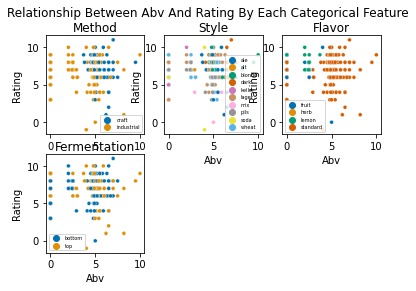

In [10]:
# Plot alcohol content vs. rating by subgroup to check for hidden patterns.

def scatter_sns(df, x_numeric_column, y_numeric_column):
    """Seaborn scatter type subplots of two numeric variables as x and y, grouped by categorical columns.
    
    Args:
    df (pandas.DataFrame): Dataframe containing numerical and categorical columns.
    x_numeric_column (str): Name of numerical column to be plotted on x-axis.
    y_numeric_column (str): Name of numerical column to be plotted on y-axis.

    Returns:
    Seaborn scatter type subplots of x and y series, split by subgroups of categorical columns used as hue.
    Title and name of axes are added automatically based on the name of x and y series.
    """

    # Store in a list the columns containing categorical data:
    list_categoricals = df.select_dtypes(include=["category"]).columns.tolist()

    # Calculate the number of subplots in the figure:
    number_of_plots = len(list_categoricals)
    # Set the number of columns to 3 because it fits most screens:
    number_of_cols = 3
    # Calculate the number of rows in which subplots are shown:
    number_of_rows = ceil(number_of_plots/number_of_cols)

    # Plot figure and set title:
    fig = plt.figure()
    fig.suptitle(f"relationship between {df[x_numeric_column].name} and {df[y_numeric_column].name} by each categorical feature".title())
    
    # Iterate through list of categorical columns:
    for i, elem in enumerate(list_categoricals):
        # Add subplots sequentially.
        # Mark the first subplot as i+1 because subplot indices start at 1, and list indeces start at 0.
        ax = fig.add_subplot(number_of_rows, number_of_cols, i+1)
        # Create each subplot, set title of subplot, labels and legend:
        sns.scatterplot(x=df[x_numeric_column], y=df[y_numeric_column], hue=elem, data=df, s=15)
        ax.set_title(elem.title(), fontsize=12, verticalalignment="bottom", y=0.95)
        ax.set(xlabel=df[x_numeric_column].name.capitalize(), ylabel=df[y_numeric_column].name.capitalize())
        ax.legend(fontsize=5, loc="best")
        # In VS Code the legend is upper left in minimized window and in best location when maximized.      
    plt.show()

scatter_sns(beer_all, "abv", "rating")

# Result 1: The scatterplot shows no linear relationship and no pattern between ratings and ABV.
# However, subgroup of lemon flavor with zero or low ABV has higher ratings compared to other groups.

### Hypothesis 2: Some subgroups might have a low number of observations and lead to overfitting the machine learning model.

In [11]:
# Create column to store status of occurrences.
beer_all["occurrence"] = np.nan

# Count occurrences in subgroups of categorical data and return df with subgroups below threshold.
def select_too_few_categorical_observations(df, categorical_columns, occurrence_column, threshold_percentage):
    """Count observations of categorical features and store result in custom column.

    If subgroup has less observations than threshold, mark them as too_few in a results column.

    Args:
    df (pandas.DataFrame): Dataframe containing categorical columns.
    categorical_columns (list): List of categorical columns.
    occurrence_column (int): Name of column that stores the count of occurrences.
    threshold_percentage (int, float): Percentage of minimum observations from total.

    Returns:
    df (pandas.DataFrame): Selection from original dataframe.
    Rows contain subgroups with counted observations less than threshold.
    """

    # Calculate the number of rows needed to pass the threshold, and print result.
    threshold = len(df)*threshold_percentage/100
    print(f"The threshold is {threshold} observations or more.")

    # Iterate through list of categorical columns and count occurrences of subgroups:
    for i, elem in enumerate(categorical_columns):
        counted = df[elem].value_counts()
        # Convert counts to dictionary:
        counted_dictionary = counted.to_dict()
        # Iterate through dictionary and store result if too_few:
        for key, value in counted_dictionary.items():
            if value < threshold:
                df.loc[df[elem] == key, occurrence_column] = "too_few"
                print(f"Too few {key} {elem}.")
    # Fill occurrence column with "enough" if the record was not marked as too_few:
    for elem in df[occurrence_column]:
        if elem != "too_few":
            df.loc[df[occurrence_column] != "too_few", occurrence_column] = "enough"
    # Select rows with too_few observations:
    too_few = df.loc[df[occurrence_column] == "too_few"]
    return too_few

# Define list of categorical features to be checked and set a threshold of 5% from the total.
categoricals = ["method", "style", "flavor", "fermentation"]
too_few_subgroups = select_too_few_categorical_observations(beer_all, categoricals, "occurrence", 5)

# Result 2: Style and Flavor columns have subgroups below the 5% threshold of the total observations.

The threshold is 12.0 observations or more.
Too few alt style.
Too few mix style.
Too few herb flavor.


### Hypothesis 3: Flavor column might have observable variation between its subgroups.

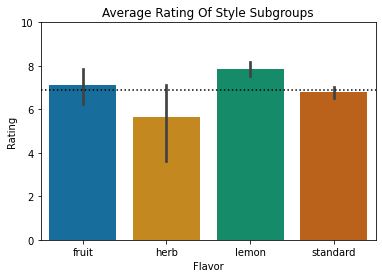

In [12]:
graph = sns.barplot(x="flavor", y="rating", data=beer_all)
graph.axhline(y=beer_all["rating"].mean(), linestyle="dotted", color="black")
graph.set(xlabel="Flavor", ylabel="Rating", title="Average Rating Of Style Subgroups")
graph.set_ylim([0, 10])
plt.show()

# Result 3: Flavor subgroups have observable variation between their average.
# The errorbar is bigger on herb subgroup.

### Hypothesis 4: Lemon beers’ high average might not be due to outliers.

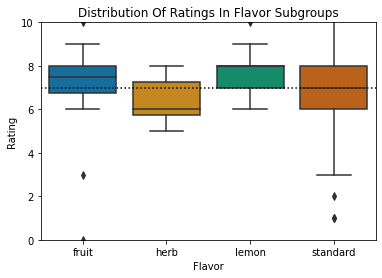

In [13]:
graph = sns.boxplot(x="flavor", y="rating", data=beer_all)
graph.axhline(y=beer_all["rating"].median(), linestyle="dotted", color="black")
graph.set(xlabel="Flavor", ylabel="Rating", title="Distribution Of Ratings In Flavor Subgroups")
graph.set_ylim([0, 10])
plt.show()

# Result 4: The boxplot shows that the distribution of lemon beers is due to higher ratings overall compared to other subgroups.
# There's no median on the lemon box. Let's find out why.

### Let's investigate what's going on with the lineless box of lemon ratings.

0.25    7.0
0.50    8.0
0.75    8.0
Name: rating, dtype: float64


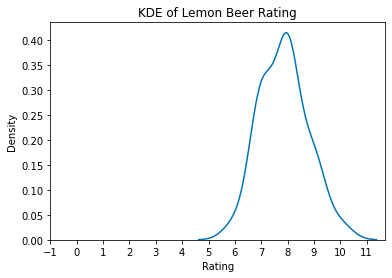

In [14]:
# Check if lemon median equals one of the quantiles, remember median is 0.50 quantile.
lemon_ratings = beer_all[beer_all["flavor"] == "lemon"]["rating"]
print(lemon_ratings.quantile([0.25, 0.50, 0.75]))
# That's it, 0.50 and 0.75 quantile are equal, so that's why the unusual boxplot.
# Both 50% and 75% of all lemon ratings are higher or equal to 8.

# Check distribution of lemon beer ratings to see if the quantile explanation matches the graph.
graph = sns.kdeplot(x=lemon_ratings)
graph.set(title="KDE of Lemon Beer Rating", xlabel="Rating")
graph.set_xticks(range(-1, 12))
plt.show()
# There's a peak of observations where the rating is 8.
# More than half of the distribution is on the left side of the 8 mark, so 75% looks plausible.

# Conclusion: The ratings of lemon beers are so much higher than the rest, that their median overlaps with its 75th percentile.

## 2.4 Verify Data Quality

### Data coverage in numerical variables.

In [15]:
# Data coverage in ratings.
unique_ratings = np.unique(beer_all["rating"])
unique_ratings_list = list(unique_ratings)
print(f"Uniques values of ratings are {unique_ratings_list}")

# Data coverage in abv.
unique_abv = np.unique(beer_all["abv"])
unique_abv_list = list(unique_abv)
print(f"Uniques values of alcohol content are {unique_abv_list}")

Uniques values of ratings are [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Uniques values of alcohol content are [0.0, 2.0, 2.1, 2.4, 2.5, 2.9, 3.0, 3.7, 3.8, 4.0, 4.1, 4.2, 4.3, 4.5, 4.7, 4.75, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.2, 6.3, 6.5, 6.7, 6.8, 7.0, 7.5, 8.2, 9.5, 10.0]


### Data coverage in categorical variables.

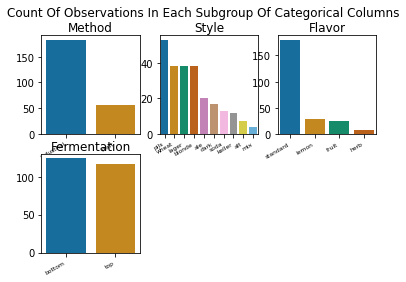

In [16]:
def countplot_sns(df):
    """Count of observations in each subgroup of categorical columns, plotted as bars.
    
    Args:
    df (pandas.DataFrame): Dataframe containing categorical columns.

    Returns:
    Seaborn countplot in subplots for co unting observations in each subgroup ofcategorical columns.
    Bars in descending order of counts.
    Axes labels are added automatically based on column names.
    """

    # Select columns with data type category:
    list_categoricals = df.select_dtypes(include=["category"]).columns.tolist()
    # Calculate the number of subplots in the figure:
    number_of_plots = len(list_categoricals)
    # Set the number of columns to 3 because it fits most screens:
    number_of_cols = 3
    # Calculate the number of rows in which subplots are shown:
    number_of_rows = ceil(number_of_plots/number_of_cols)

    # Plot figure and set title:
    fig = plt.figure()
    fig.suptitle("count of observations in each subgroup of categorical columns".title())
    # Iterate through list of categorical columns:
    for i, elem in enumerate(list_categoricals):
        # Define bar sorting criteria as descending counts:
        desc_order = df[elem].value_counts().index
        # Add subplots sequentially.
        # Mark the first subplot as i+1 because subplot indices start at 1, and list indeces start at 0.
        ax = fig.add_subplot(number_of_rows, number_of_cols, i+1)
        # Create each subplot, set labels and legend:
        sns.countplot(x=elem, data=df, order=desc_order)
        ax.set_title(elem.title(), fontsize=12, verticalalignment="bottom", y=0.95)
        ax.set_xticklabels(desc_order, fontsize=6, rotation=30, horizontalalignment="right", verticalalignment="top")
        ax.set(xlabel="", ylabel="")
    plt.show()

countplot_sns(beer_all)
# Size of subgroups consistent with stores' assortment.

# STEP 3. DATA PREPARATION

## 3.1 Select Data

### 3.1.1 Distribution of ratings.

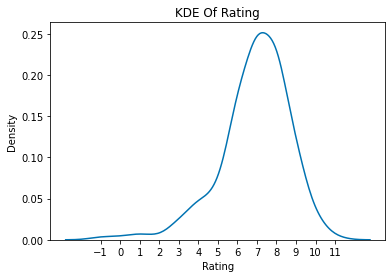

In [17]:
graph = sns.kdeplot(x=beer_all["rating"])
graph.set(title="KDE Of Rating", xlabel="Rating")
graph.set_xticks(range(-1, 12))
plt.show()
# Curve of ratings KDE is gaussian.

### 3.1.2 Distribution of alcohol content.

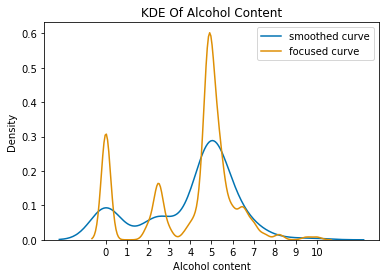

Alcohol-free are 17.08% of total beer.


In [18]:
# Commercial beer is either regular, alcohol-free, or lemonade mix, and a smooth curve hides these groups.
# Set bandwidth lower than 1 to check if groups show up.  
graph = sns.kdeplot(x=beer_all["abv"], label="smoothed curve")
graph = sns.kdeplot(x=beer_all["abv"], bw_adjust=0.3, label="focused curve")
graph.set(title="KDE Of Alcohol Content", xlabel="Alcohol content")
graph.set_xticks(range(0, 11))
graph.legend()
plt.show()
# Curve of alcohol content KDE is not gaussian.
# Still, it shows a pattern of three subgroups each with its own gaussian curve.

# Check proportion of alcohol-free beer because it influences the curve of alcohol content.
abv_list = beer_all["abv"].tolist()
abv_zero = (abv_list.count(0)/len(abv_list))*100
print(f"Alcohol-free are {abv_zero:.2f}% of total beer.")

### 3.1.3 Combined distribution of alcohol content and ratings.

Spearman's correlation: -0.11.


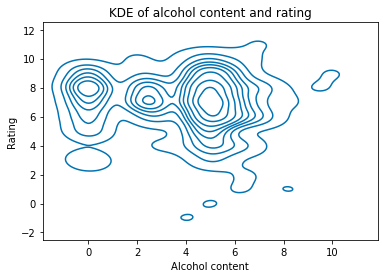

In [19]:
# Calculate Spearman's correlation coefficient because it works for non-linear relationship if the variables are monotonic.
spearman_corr, _ = spearmanr(beer_all["abv"], beer_all["rating"])
print(f"Spearman\'s correlation: {spearman_corr:.2f}.")
# Result: -0.11, so if they have any kind of relationship, it is not monotonic.
# The scatterplot between abv and rating is consistent with Spearman's correlation coefficient.

# Plot KDE of alcohol content and rating. Set bandwidth less than 1 because distribution of ABV is not gaussian.
graph = sns.kdeplot(data=beer_all, x=beer_all["abv"], y=beer_all["rating"], bw_adjust=0.7)
graph.set(title="KDE of alcohol content and rating", xlabel="Alcohol content", ylabel="Rating")
plt.show() 
# There are three zones, so it makes sense to split the dataset into three groups after all cleanup is done.

### 3.1.4 Check country column if it has enough observations for each unique value, otherwise drop the column.

In [20]:
# Count occurrences for each country.
country_count = beer_all["country"].value_counts()

# Count occurrences for each country as percentage.
country_percentage = beer_all["country"].value_counts(normalize=True).mul(100).round(1)

# Collect all results in one dataframe.
country_stats = pd.DataFrame({"observations": country_count, "percentage": country_percentage})
# print(country_stats)
# There are 17 unique countries and 15 of them have each less than 5% of the total observations.

# Drop country column.
beer_all = beer_all.drop("country", 1)

### 3.1.5 Check which categorical features have high variation across subgroups for building models.

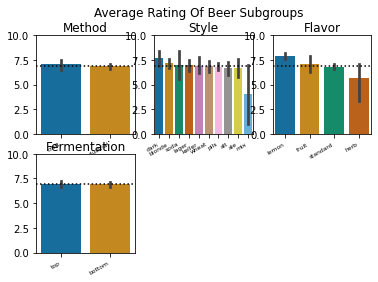

In [21]:
# Plot ratings variation in subgroups across categorical features.

def barplot_sns(df, y_numeric_column, graph_title, categorical_columns=None):
    """Seaborn subplots of bars showing mean of numeric column grouped by categorical columns.
    If list of categorical columns is not provided, uses columns of category type from dataframe.
    
    Args:
    df (pandas.DataFrame): Dataframe containing numerical and categorical columns.
    y_series (str): Name of numerical column.
    graph_title (str): Title of graph.
    categorical_columns (list, optional): List of categorical columns.

    Returns:
    Seaborn subplots of bars with mean of each subgroup in categorical columns.
    Horizontal line to mark the mean of each column. Bars in descending order of mean.
    Axes labels are added automatically based on column names.
    """
    # Check if input contains list of categorical columns. If not, select columns with data type category:
    if categorical_columns != None:
        list_categoricals = categorical_columns
    else:
        list_categoricals = df.select_dtypes(include=["category"]).columns.tolist()
    
    # Calculate the number of subplots in the figure:
    number_of_plots = len(list_categoricals)
    # Set the number of columns to 3 because it fits most screens:
    number_of_cols = 3
    # Calculate the number of rows in which subplots are shown:
    number_of_rows = ceil(number_of_plots/number_of_cols)

    # Plot figure and set title:
    fig = plt.figure()
    fig.suptitle(graph_title.title())
    # Iterate through list of categorical columns:
    for i, elem in enumerate(list_categoricals):
    # Define bar sorting criteria as descending mean:
        desc_order = list(df.groupby(elem)[y_numeric_column].mean().reset_index().sort_values(by=y_numeric_column, ascending=False)[elem])
        # Add subplots sequentially.
        # Mark the first subplot as i+1 because subplot indices start at 1, and list indeces start at 0.
        ax = fig.add_subplot(number_of_rows, number_of_cols, i+1)
        # Create each subplot, set horizontal line to mark the mean, set labels and legend:
        sns.barplot(x=elem, y=y_numeric_column, data=df, order=desc_order, dodge=False)
        ax.axhline(y=df[y_numeric_column].mean(), linestyle="dotted", color="black")
        ax.set_title(elem.title(), fontsize=12, verticalalignment="bottom", y=0.95)
        ax.set_xticklabels(desc_order, fontsize=6, rotation=30, horizontalalignment="right", verticalalignment="top")
        ax.set(xlabel="", ylabel="")
        ax.set_ylim([0, 10])
        
    plt.show()
 
barplot_sns(beer_all, "rating", "average rating of beer subgroups", categoricals)


# The barplot shows Flavor and Style have high variation between the average of their subgroups.
# Method and Fermentation have low variation across their subgroups.
# Errorbars are bigger on subgroups with low number of observations.

### Explain sequence for sorting bars of categoricals by value counts (numerical values) in the previous function. Use subgroups of flavor column as example.

In [22]:
# Start grouping all rows by flavor and select only the rating column, then calculate its mean.
# Reset the index to avoid future errors.
grouped = beer_all.groupby("flavor")["rating"].mean().reset_index()
# Then sort this series by ratings in descending order and select flavor labels.
ordered = grouped.sort_values(by="rating", ascending=False)["flavor"]
# Lastly, turn these grouped and ordered flavor labels into a list ready to use when creating graphs.
stored_in_list = list(ordered)
# In a more concise (and hard to read) line, the flow looks like this:
desc_order = list(beer_all.groupby("flavor")["rating"].mean().reset_index().sort_values(by="rating", ascending=False)["flavor"])

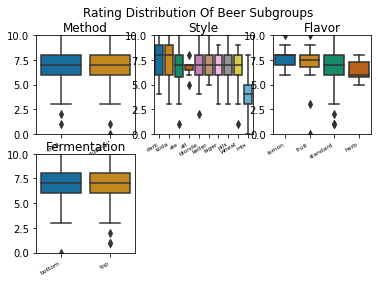

In [23]:
# Abstract representation of ratings distribution. Take a look at median, IQR, whiskers, outliers.

def boxplot_sns(df, y_numeric_column, graph_title, categorical_columns=None):
    """Seaborn subplots with boxplots of subgroups' distribution in categorical columns.
    If list of categorical columns is not provided, uses columns of category type from dataframe.
    
    Args:
    df (pandas.DataFrame): Dataframe containing numerical and categorical columns.
    y_series (str): Name of numerical column.
    graph_title (str): Title for graph.
    categorical_columns (list, optional): List of categorical columns.

    Returns:
    Seaborn subplots of boxplots showing distribution of subgroups in categorical columns.
    Boxes in descending order of median.
    Axes labels are added automatically based on column names.
    """

    # Check if input contains list of categorical columns. If not, select columns with data type category:
    if categorical_columns != None:
        list_categoricals = categorical_columns
    else:
        list_categoricals = df.select_dtypes(include=["category"]).columns.tolist()
    
    # Calculate the number of subplots in the figure:
    number_of_plots = len(list_categoricals)
    # Set the number of columns to 3 because it fits most screens:
    number_of_cols = 3
    # Calculate the number of rows in which subplots are shown:
    number_of_rows = ceil(number_of_plots/number_of_cols)
    
    # Plot figure and set title:
    fig = plt.figure()
    fig.suptitle(graph_title.title())
    # Iterate through list of categorical columns:
    for i, elem in enumerate(list_categoricals):
        # Define box sorting criteria as descending median:
        desc_order = list(df.groupby(elem)[y_numeric_column].median().reset_index().sort_values(by=y_numeric_column, ascending=False)[elem])
        # Add subplots sequentially.
        # Mark the first subplot as i+1 because subplot indices start at 1, and list indeces start at 0.
        ax = fig.add_subplot(number_of_rows, number_of_cols, i+1)
        # Create each subplot, set labels and legend:
        sns.boxplot(x=elem, y=y_numeric_column, data=df, order=desc_order)
        ax.set_title(elem.title(), fontsize=12, verticalalignment="bottom", y=0.95)
        ax.set_xticklabels(desc_order, fontsize=6, rotation=30, horizontalalignment="right", verticalalignment="top")
        ax.set(xlabel="", ylabel="")
        ax.set_ylim([0, 10])

    plt.show()

boxplot_sns(beer_all, "rating", "Rating distribution of beer subgroups", categoricals)

# The boxplot shows Flavor and Style have high variation between the distributions of their subgroups.
# Method and Fermentation have low variation across their subgroups.
# Errorbars are bigger on subgroups with low number of observations.

## 3.2 Clean data.

In [24]:
# Define range of normal ratings as 2*std away from the mean because dataset is small and has gaussian distribution.
mean_rating = beer_all["rating"].mean()
std_rating = beer_all["rating"].std()
two_std_rating = std_rating * 2

lower_limit_rating = mean_rating - two_std_rating
upper_limit_rating = mean_rating + two_std_rating

print(f"The mean rating is {mean_rating:.2f}.")
print(f"The lower limit of normal ratings is {lower_limit_rating:.2f} and the upper limit is {upper_limit_rating:.2f}.")

# Identify rating outliers. Use result to train machine learning model and avoid overfitting.
outlier_ratings = [x for x in beer_all["rating"] if x < lower_limit_rating or x > upper_limit_rating]
outlier_ratings.sort()
# print(f"These are the rating outliers: {outlier_ratings}")
print(f"There are {len(outlier_ratings)} outliers out of {len(beer_all.rating)} total rating observations.")

The mean rating is 6.90.
The lower limit of normal ratings is 3.33 and the upper limit is 10.48.
There are 12 outliers out of 240 total rating observations.


## 3.3 Construct Data

### 3.3.1 Derived Attributes.

In [25]:
# Create column for filtration status.
unfiltered_words = ["unfiltered", "kellerbier", "natur", "naturtrubes", "nefiltrata", "nonfiltrata"]
beer_all["filtration"] = beer_all["name"].str.contains("|".join(unfiltered_words))
beer_all["filtration"] = beer_all["filtration"].replace({True: "unfiltered", False: "filtered"})

# Create column for pasteurization status.
unpasteurized_words = ["unpasteurized", "kellerbier", "natur", "naturtrubes", "nepasteurizata", "nonpastorizzata"]
beer_all["pasteurization"] = beer_all["name"].str.contains("|".join(unpasteurized_words))
beer_all["pasteurization"] = beer_all["pasteurization"].replace({True: "unpasteurized", False: "pasteurized"})

# Format the new columns as categoricals.
beer_all[["filtration", "pasteurization"]] = beer_all[["filtration", "pasteurization"]].astype("category")

### 3.3.2 Generated records.

In [26]:
# Create column to bin alcohol content as categorical data.
abv_bins = [0, 0.5, 2.8, 4.4, 5.5, 10]
perception_labels = ["drive", "refresh", "weak", "tasty", "too_strong"]
beer_all["perception"] = pd.cut(beer_all["abv"], bins=abv_bins, labels=perception_labels, include_lowest=True)

## 3.4 Integrate Data

In [27]:
# 3.4.1 Select observations with ratings less than 2*std away from the mean. Use limits calculated at 3.2 and reset index.
outlier_condition = (beer_all.rating < lower_limit_rating) | (beer_all.rating > upper_limit_rating)
beer_2std = beer_all.drop(beer_all[outlier_condition].index)
beer_2std.reset_index(inplace=True, drop=True)
print(f"Dataframe without outliers has {len(beer_2std.rating)} rows.")
# Check this out, below selection by square brackets doesn't work in f-string, must use dot notation.
# print(f"There are {len(beer_2std["rating"])} observations with normal ratings.")

Dataframe without outliers has 228 rows.


In [28]:
# 3.4.2 Split dataset by alcohol content into three subsets: alcohol-free, light and regular beer.
alc_free_all = beer_all[beer_all["abv"] <= 0.5]
light_all = beer_all[(beer_all["abv"] > 0.5) & (beer_all["abv"] <= 3)]
regular_all = beer_all[beer_all["abv"] > 3]

alc_free_2std = beer_2std[beer_2std["abv"] <= 0.5]
light_2std = beer_2std[(beer_2std["abv"] > 0.5) & (beer_2std["abv"] <= 3)]
regular_2std = beer_2std[beer_2std["abv"] > 3]

print(f"In complete ratings range there are {len(alc_free_all)} alcohol-free, {len(light_all)} light and {len(regular_all)} regular beers.")
print(f"In less than 2*std away ratings there are {len(alc_free_2std)} alcohol-free, {len(light_2std)} light and {len(regular_2std)} regular beers.")

In complete ratings range there are 41 alcohol-free, 30 light and 169 regular beers.
In less than 2*std away ratings there are 38 alcohol-free, 30 light and 160 regular beers.


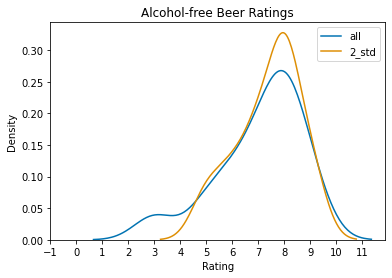

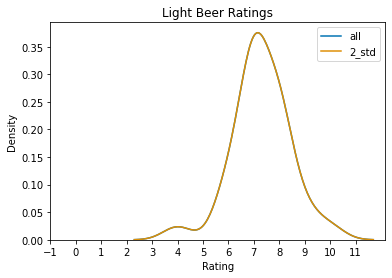

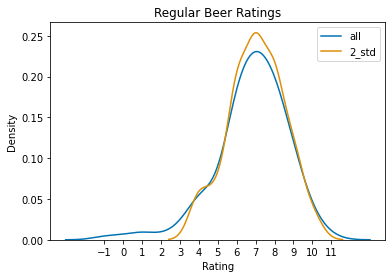

In [29]:
# 3.4.3 Check distribution of ratings in subsets
# Plot distribution of ratings in each subset to check if their curves are gaussian.
graph = sns.kdeplot(x=alc_free_all["rating"], label="all")
graph = sns.kdeplot(x=alc_free_2std["rating"], label="2_std")
graph.set(title="Alcohol-free Beer Ratings", xlabel="Rating")
graph.set_xticks(range(-1, 12))
plt.legend()
plt.show()

graph = sns.kdeplot(x=light_all["rating"], label="all")
graph = sns.kdeplot(x=light_2std["rating"], label="2_std")
graph.set(title="Light Beer Ratings", xlabel="Rating")
graph.set_xticks(range(-1, 12))
plt.legend()
plt.show()

graph = sns.kdeplot(x=regular_all["rating"], label="all")
graph = sns.kdeplot(x=regular_2std["rating"], label="2_std")
graph.set(title="Regular Beer Ratings", xlabel="Rating")
graph.set_xticks(range(-1, 12))
plt.legend()
plt.show()
# KDE plots of the six subsets prove that ratings keep their gaussian curve even if split by alcohol content criteria.

In [30]:
# Create a dictionary that stores datasets as values and their names as keys.
clean_dataframes = [beer_all, alc_free_all, light_all, regular_all, beer_2std, alc_free_2std, light_2std, regular_2std]
dataframe_names = ["beer_all", "alc_free_all", "light_all", "regular_all", "beer_2std", "alc_free_2std", "light_2std", "regular_2std"]

dataframes_dict = dict(zip(dataframe_names, clean_dataframes))

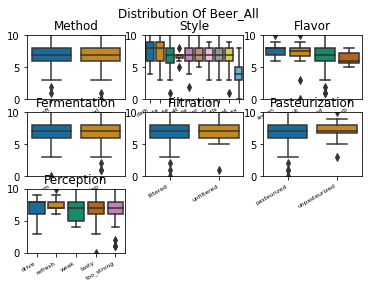

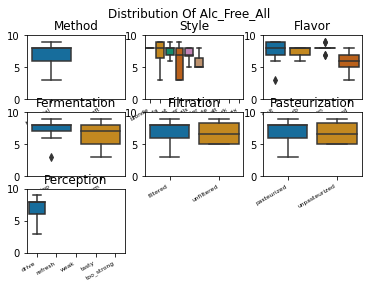

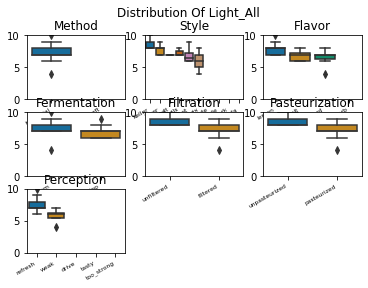

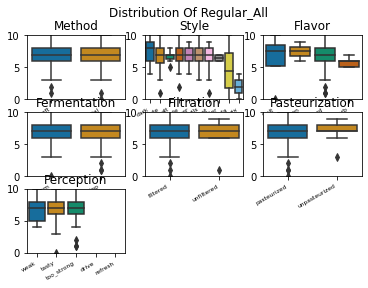

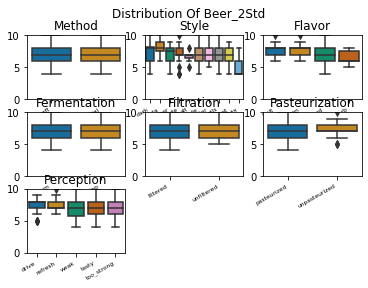

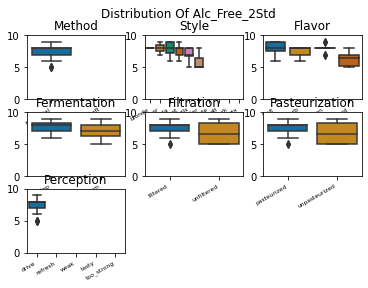

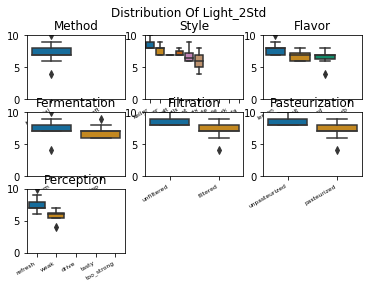

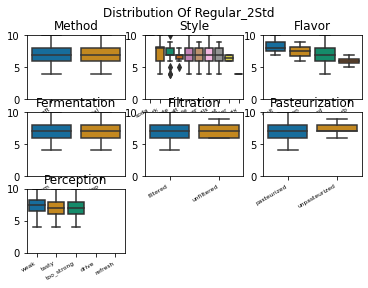

In [31]:
# 3.4.4 Check feature variation across subgroups when split into the three subsets based on alcohol content.

for key, value in dataframes_dict.items():
    boxplot_sns(value, "rating", f"Distribution of {key}")
    plt.show()

# All subsets have higher variation in Style and Flavor, and no variation in Method.
# Some subsets have a bit of variation in Filtration, Pasteurization, Fermentation and Perception.

## 3.5 Format Data

In [32]:
# Sort df on ABV, then on rating.
beer_all.sort_values(["rating", "abv"], ascending=[True, True], inplace=True)

## 3.6 Dataset - output.

In [33]:
# Export dataframes and remove index because beer identification is done through their unique name.
# It's also good to avoid having two columns with indices next time the file is imported.

def export_files_csv(dataframes_dictionary, output_folder):
    """Export dictionary of pandas DataFrames to csv files
    Must have names as keys and dataframes as values.

    Args:
    dataframes_dictionary (dict): Dictionary of dataframes to be exported.
    output_folder (str): Path to folder where to export result.

    Returns:
    csv files.
    """

    for key, value in dataframes_dictionary.items():
        output_address = output_folder + str(key) + ".csv"
        value.to_csv(output_address, index=False)

# Path to folder containing clean files.
clean_files_path = os.getcwd() + os.sep + "beer_output" + os.sep + "cleaning_output" + os.sep

export_files_csv(dataframes_dict, clean_files_path)

## 3.7 Dataset Description

In [34]:
# Print total number of columns, rows and ratings lower than 5.
# Print description of categorical columns.

for key, value in dataframes_dict.items():
    total_rows = value.shape[0]
    lower_than_five = value[value["rating"] < 5]
    only_lows = lower_than_five.shape[0]
    total_columns = value.shape[1]
    print(f"{key} \nRows: {total_rows} \nNumber of ratings lower than 5: {only_lows} \nColumns: {total_columns} \n")
    describe_categorical_columns(value, "rating")

beer_all 
Rows: 240 
Number of ratings lower than 5: 23 
Columns: 12 

            count  mean  std  min  25%  50%  75%   max
method                                                
craft        57.0   7.0  1.9  1.0  6.0  7.0  8.0  11.0
industrial  183.0   6.9  1.7 -1.0  6.0  7.0  8.0  10.0
        count  mean  std  min  25%  50%  75%   max
style                                             
ale      20.0   6.6  2.3  1.0  5.8  7.0  8.0  10.0
alt       7.0   6.7  1.0  5.0  6.5  7.0  7.0   8.0
blonde   38.0   7.1  1.5  2.0  6.0  7.0  8.0  10.0
dark     17.0   7.6  1.7  4.0  6.0  8.0  9.0  11.0
keller   12.0   6.9  1.4  5.0  6.0  7.0  8.0  10.0
lager    38.0   6.9  1.7  3.0  6.0  7.0  8.0   9.0
mix       4.0   4.0  3.3  0.0  3.0  4.0  5.0   8.0
pils     53.0   6.8  1.4  3.0  6.0  7.0  8.0  10.0
soda     13.0   7.0  3.0 -1.0  6.0  8.0  9.0  10.0
wheat    38.0   6.9  1.7  1.0  6.0  7.0  8.0   9.0
          count  mean  std  min  25%  50%  75%   max
flavor                                      

# STEP 4. MODELING. MACHINE LEARNING WITH H2O

### Initialize H2O

In [35]:
# Assertions are disabled because they are mainly used for error checking and debugging purposes.
# nthreads=-1 means use all CPU on the host
h2o.init(nthreads=-1, enable_assertions=False)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.7+8-LTS, mixed mode)
  Starting server from E:\Python382\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\alina\AppData\Local\Temp\tmpv9w6hhwv
  JVM stdout: C:\Users\alina\AppData\Local\Temp\tmpv9w6hhwv\h2o_alina_started_from_python.out
  JVM stderr: C:\Users\alina\AppData\Local\Temp\tmpv9w6hhwv\h2o_alina_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.5
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_alina_lo1sxu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.971 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


### Collect .csv files.

In [36]:
# Select clean files.
clean_files = glob.glob(clean_files_path + "*.csv")

### Import datasets as dictionaries into H2O.

In [37]:
# Write function to import multiple files at once.

def files_to_h2o_frames(files, response_column):
    """Import files into H2O frames.
    
    Args:
    files (list): List of files to be imported.
    response_column (str): Name of response column.

    Returns:
    dict: Dictionary containing H2O frames, predictors and response.
    Key: the name of a dataset. Values: the imported frame, its list of predictors, the response column.
    """

    # Create empty dictionary to be populated at each iteration.
    dictionary = {}

    # Iterate through list of files to create name, frame and list of predictors.
    for i, elem in enumerate(files):
        name = PureWindowsPath(elem).stem
        frame = h2o.import_file(elem)
        if "beer" in name:
            predictors = ["style", "flavor", "perception", "abv"]
        elif "alc_free" in name:
            predictors = ["style", "flavor"]
        elif "light" in name:
            predictors = ["style", "flavor", "abv"]
        else:
            predictors = ["style", "flavor", "pasteurization", "abv"]

        # Add key and values to dictionary.
        dictionary[name] = {"frame":frame, "predictors":predictors, "response": response_column}
    return dictionary

frames_dictionary = files_to_h2o_frames(clean_files, "rating")

# Print the resulting dictionaries to check if datasets have the correct predictors.
print(frames_dictionary)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


name,rating,method,style,flavor,fermentation,split,abv,occurrence,filtration,pasteurization,perception
ariana radler malina raspberry 0.0,9,industrial,lager,lemon,bottom,train,0,enough,filtered,pasteurized,drive
beck's blue 0.0,5,industrial,pils,standard,bottom,train,0,enough,filtered,pasteurized,drive
bitburger pils 0.0,7,industrial,pils,standard,bottom,train,0,enough,filtered,pasteurized,drive
bitburger radler 0.0,8,industrial,pils,lemon,bottom,train,0,enough,filtered,pasteurized,drive
bundaberg ginger brew 0.0,9,industrial,soda,fruit,top,train,0,enough,filtered,pasteurized,drive
carter's root beer 0.0,6,industrial,soda,herb,top,valid,0,too_few,filtered,pasteurized,drive
clausthaler extra herb 0.0,8,industrial,pils,herb,bottom,test,0,too_few,filtered,pasteurized,drive
clausthaler naturtrub 0.0,5,industrial,keller,standard,bottom,train,0,enough,unfiltered,unpasteurized,drive
clausthaler original 0.0,7,industrial,pils,standard,bottom,valid,0,enough,filtered,pasteurized,drive
clausthaler radler 0.0,8,industrial,pils,lemon,bottom,test,0,enough,filtered,pasteurized,drive


name,rating,method,style,flavor,fermentation,split,abv,occurrence,filtration,pasteurization,perception
ariana radler malina raspberry 0.0,9,industrial,lager,lemon,bottom,train,0,enough,filtered,pasteurized,drive
beck's blue 0.0,5,industrial,pils,standard,bottom,train,0,enough,filtered,pasteurized,drive
bitburger pils 0.0,7,industrial,pils,standard,bottom,train,0,enough,filtered,pasteurized,drive
bitburger radler 0.0,8,industrial,pils,lemon,bottom,train,0,enough,filtered,pasteurized,drive
bundaberg ginger brew 0.0,9,industrial,soda,fruit,top,train,0,enough,filtered,pasteurized,drive
carter's root beer 0.0,6,industrial,soda,herb,top,valid,0,too_few,filtered,pasteurized,drive
clausthaler extra herb 0.0,8,industrial,pils,herb,bottom,test,0,too_few,filtered,pasteurized,drive
clausthaler naturtrub 0.0,5,industrial,keller,standard,bottom,train,0,enough,unfiltered,unpasteurized,drive
clausthaler original 0.0,7,industrial,pils,standard,bottom,valid,0,enough,filtered,pasteurized,drive
clausthaler radler 0.0,8,industrial,pils,lemon,bottom,test,0,enough,filtered,pasteurized,drive


name,rating,method,style,flavor,fermentation,split,abv,occurrence,filtration,pasteurization,perception
2.5 original 2.5,7,industrial,pils,standard,bottom,valid,2.5,enough,filtered,pasteurized,refresh
affligem double 6.8,6,craft,blonde,standard,top,test,6.8,enough,filtered,pasteurized,too_strong
aktien original 1857 5.3,7,industrial,lager,standard,bottom,valid,5.3,enough,filtered,pasteurized,tasty
allgauer buble bier helles edelbrau 5.5,8,industrial,blonde,standard,top,train,5.5,enough,filtered,pasteurized,tasty
altenmunster urig wurzig 4.9,5,industrial,lager,herb,bottom,train,4.9,too_few,filtered,pasteurized,tasty
angelo poretti bock chiara 6.5,4,craft,dark,standard,bottom,train,6.5,enough,filtered,pasteurized,too_strong
antoniana marechiaro 5.2,6,industrial,blonde,standard,top,test,5.2,enough,filtered,pasteurized,tasty
antoniana scudata bionda 5.2,7,industrial,blonde,standard,top,train,5.2,enough,filtered,pasteurized,tasty
ariana lager 4.5,7,industrial,lager,standard,bottom,train,4.5,enough,filtered,pasteurized,tasty
ariana radler malina raspberry 0.0,9,industrial,lager,lemon,bottom,train,0,enough,filtered,pasteurized,drive


name,rating,method,style,flavor,fermentation,split,abv,occurrence,filtration,pasteurization,perception
crabbies original alcoholic ginger beer 4.0,-1,industrial,soda,herb,top,valid,4,too_few,filtered,pasteurized,weak
mixery iced blue bier guarana energy drink 5.0,0,industrial,mix,fruit,bottom,train,5,too_few,filtered,pasteurized,tasty
capra noastra nr. 5 india pale ale aramica nefiltrata 6.2,1,craft,ale,standard,top,train,6.2,enough,unfiltered,pasteurized,too_strong
schneider weisse tap5 8.2,1,industrial,wheat,standard,top,train,8.2,enough,filtered,pasteurized,too_strong
belhaven speyside oak aged blonde ale 6.5,2,craft,blonde,standard,top,train,6.5,enough,filtered,pasteurized,too_strong
gaffels fassbrause orange 0.0,3,industrial,soda,fruit,top,train,0,enough,filtered,pasteurized,drive
karamalz 0.0,3,industrial,lager,standard,bottom,train,0,enough,filtered,pasteurized,drive
paderborner malz 0.0,3,industrial,lager,standard,bottom,train,0,enough,filtered,pasteurized,drive
landfurst premium pils 4.8,3,industrial,pils,standard,bottom,test,4.8,enough,filtered,pasteurized,tasty
red revolution nepasteurizata 5.0,3,craft,ale,standard,top,train,5,enough,filtered,unpasteurized,tasty


name,rating,method,style,flavor,fermentation,split,abv,occurrence,filtration,pasteurization,perception
2.5 original 2.5,7,industrial,pils,standard,bottom,valid,2.5,enough,filtered,pasteurized,refresh
astra kiezmische 2.5,7,industrial,pils,standard,bottom,valid,2.5,enough,filtered,pasteurized,refresh
beck's green lemon 2.5,7,industrial,pils,lemon,bottom,valid,2.5,enough,filtered,pasteurized,refresh
beck's ice lime & mint 2.5,8,industrial,pils,lemon,bottom,train,2.5,enough,filtered,pasteurized,refresh
beck's red holunder 2.5,7,industrial,pils,fruit,bottom,train,2.5,enough,filtered,pasteurized,refresh
berliner kindl weisse himbeere 3.0,6,industrial,wheat,fruit,top,train,3,enough,filtered,pasteurized,weak
berliner kindl weisse original 3.0,6,industrial,wheat,standard,top,test,3,enough,filtered,pasteurized,weak
diebels dimix bier cola 2.9,4,industrial,mix,standard,bottom,train,2.9,too_few,filtered,pasteurized,weak
diebels light 2.9,7,industrial,alt,standard,top,valid,2.9,too_few,filtered,pasteurized,weak
falkenfelster radler naturtrub 2.5,8,industrial,keller,lemon,bottom,train,2.5,enough,unfiltered,unpasteurized,refresh


name,rating,method,style,flavor,fermentation,split,abv,occurrence,filtration,pasteurization,perception
2.5 original 2.5,7,industrial,pils,standard,bottom,valid,2.5,enough,filtered,pasteurized,refresh
astra kiezmische 2.5,7,industrial,pils,standard,bottom,valid,2.5,enough,filtered,pasteurized,refresh
beck's green lemon 2.5,7,industrial,pils,lemon,bottom,valid,2.5,enough,filtered,pasteurized,refresh
beck's ice lime & mint 2.5,8,industrial,pils,lemon,bottom,train,2.5,enough,filtered,pasteurized,refresh
beck's red holunder 2.5,7,industrial,pils,fruit,bottom,train,2.5,enough,filtered,pasteurized,refresh
berliner kindl weisse himbeere 3.0,6,industrial,wheat,fruit,top,train,3,enough,filtered,pasteurized,weak
berliner kindl weisse original 3.0,6,industrial,wheat,standard,top,test,3,enough,filtered,pasteurized,weak
diebels dimix bier cola 2.9,4,industrial,mix,standard,bottom,train,2.9,too_few,filtered,pasteurized,weak
diebels light 2.9,7,industrial,alt,standard,top,valid,2.9,too_few,filtered,pasteurized,weak
falkenfelster radler naturtrub 2.5,8,industrial,keller,lemon,bottom,train,2.5,enough,unfiltered,unpasteurized,refresh


name,rating,method,style,flavor,fermentation,split,abv,occurrence,filtration,pasteurization,perception
affligem double 6.8,6,craft,blonde,standard,top,test,6.8,enough,filtered,pasteurized,too_strong
aktien original 1857 5.3,7,industrial,lager,standard,bottom,valid,5.3,enough,filtered,pasteurized,tasty
allgauer buble bier helles edelbrau 5.5,8,industrial,blonde,standard,top,train,5.5,enough,filtered,pasteurized,tasty
altenmunster urig wurzig 4.9,5,industrial,lager,herb,bottom,train,4.9,too_few,filtered,pasteurized,tasty
angelo poretti bock chiara 6.5,4,craft,dark,standard,bottom,train,6.5,enough,filtered,pasteurized,too_strong
antoniana marechiaro 5.2,6,industrial,blonde,standard,top,test,5.2,enough,filtered,pasteurized,tasty
antoniana scudata bionda 5.2,7,industrial,blonde,standard,top,train,5.2,enough,filtered,pasteurized,tasty
ariana lager 4.5,7,industrial,lager,standard,bottom,train,4.5,enough,filtered,pasteurized,tasty
astra rotlicht 6.0,6,industrial,pils,standard,bottom,train,6,enough,filtered,pasteurized,too_strong
astra urtyp 4.9,8,industrial,pils,standard,bottom,test,4.9,enough,filtered,pasteurized,tasty


name,rating,method,style,flavor,fermentation,split,abv,occurrence,filtration,pasteurization,perception
affligem double 6.8,6,craft,blonde,standard,top,test,6.8,enough,filtered,pasteurized,too_strong
aktien original 1857 5.3,7,industrial,lager,standard,bottom,valid,5.3,enough,filtered,pasteurized,tasty
allgauer buble bier helles edelbrau 5.5,8,industrial,blonde,standard,top,train,5.5,enough,filtered,pasteurized,tasty
altenmunster urig wurzig 4.9,5,industrial,lager,herb,bottom,train,4.9,too_few,filtered,pasteurized,tasty
angelo poretti bock chiara 6.5,4,craft,dark,standard,bottom,train,6.5,enough,filtered,pasteurized,too_strong
antoniana marechiaro 5.2,6,industrial,blonde,standard,top,test,5.2,enough,filtered,pasteurized,tasty
antoniana scudata bionda 5.2,7,industrial,blonde,standard,top,train,5.2,enough,filtered,pasteurized,tasty
ariana lager 4.5,7,industrial,lager,standard,bottom,train,4.5,enough,filtered,pasteurized,tasty
astra rotlicht 6.0,6,industrial,pils,standard,bottom,train,6,enough,filtered,pasteurized,too_strong
astra urtyp 4.9,8,industrial,pils,standard,bottom,test,4.9,enough,filtered,pasteurized,tasty


{'alc_free_2std': {'frame': , 'predictors': ['style', 'flavor'], 'response': 'rating'}, 'alc_free_all': {'frame': , 'predictors': ['style', 'flavor'], 'response': 'rating'}, 'beer_2std': {'frame': , 'predictors': ['style', 'flavor', 'perception', 'abv'], 'response': 'rating'}, 'beer_all': {'frame': , 'predictors': ['style', 'flavor', 'perception', 'abv'], 'response': 'rating'}, 'light_2std': {'frame': , 'predictors': ['style', 'flavor', 'abv'], 'response': 'rating'}, 'light_all': {'frame': , 'predictors': ['style', 'flavor', 'abv'], 'response': 'rating'}, 'regular_2std': {'frame': , 'predictors': ['style', 'flavor', 'pasteurization', 'abv'], 'response': 'rating'}, 'regular_all': {'frame': , 'predictors': ['style', 'flavor', 'pasteurization', 'abv'], 'response': 'rating'}}


### 4.1 Select Modeling Techniques.

In [38]:
# I have selected Distributed Random Forest (DRF), Gradient Boosting Machine (GBM) - see motives in Final Report file.

### 4.2 Generate Test Design.

In [39]:
# The model will learn from the training set and will be assessed on the test set.
# Train 0.7, valid 0.15 and test 0.15 splits were decided manually to ensure they are diverse no matter how few observations there are.
# See note in Readme file.

### 4.3 Build Models.

### 4.3.1 Parameter Settings

### 4.3.2 Define Models

### Distributed Random Forest - DRF.

In [40]:
# Write function to generate DRF model and export prediction as pandas dataframe.

def model_h2o_drf(frames, pred_output_folder, mse_output_folder):
    """Build DRF model in H2O for each dataset, add prediction to pandas dataframe, export result and MSE as csv.

    Args:
    frames (dict): Dictionary containing frames, predictors and response column.
    pred_output_folder (str): Path to folder where to export DRF model.
    mse_output_folder (str): Path to folder where to export file with MSE of all DRF models.

    Returns:
    zip archive of each model
    csv file with predictions of each model
    csv file with MSE of all DRF models
    """

    # Create list of model names.
    model_names = []

    # Create list of MSE results from each model.
    mse_list = []

    # Iterate through dictionary and store its elements under short variable names to help with readability:
    for key, value in frames.items():
        # Access the name.
        name = str(key)+ "_drf"

        # Append model name to list.
        model_names.append(name)

        # Access the frame.
        frame = frames[key]["frame"]
        # Access the predictors.
        predictor_list = frames[key]["predictors"]
        # Access the response.
        response_column = frames[key]["response"]

        # Split rows into training, validation and test sets. This makes reproducibility possible.
        train = frame[frame["split"]=="train"]
        valid = frame[frame["split"]=="valid"]
        test = frame[frame["split"]=="test"]

        # Instantiate model with custom parameters.   
        model = H2ORandomForestEstimator(seed=12, categorical_encoding="Enum", nfolds=4, fold_assignment="random", 
        mtries=len(predictor_list), nbins=13, nbins_top_level=16, build_tree_one_node=True)

        # Train model. Specify predictors, response column, training frame and validation frame.
        model.train(x=predictor_list, y=response_column, training_frame=train, validation_frame=valid, model_id=name+"_model")

        # Print model to show variable importance.
        # print(model)

        # Export model.
        model_file = model.download_mojo(path=os.getcwd() + os.sep + "beer_output" + os.sep + "models" + os.sep + "drf_models", get_genmodel_jar=False)

        # Generate prediction. It gets stored in a H2O frame with one column named "predict".
        prediction = model.predict(frame)

        # Calculate model performance on test set.
        performance = model.model_performance(test)

        # Store model performance as json into a dictionary.
        perf_dict = performance._metric_json

        # Select only MSE from performance dictionary. Use ndarray.item method to catch errors in case MSE output is not a float.
        mse_value = np.asarray([value for key, value in perf_dict.items() if key == "MSE"]).item()
        
        # Append MSE list.
        mse_list.append(mse_value)

        # Print model name, predictor list and MSE.
        print(f"This is DRF {name} model trained on {predictor_list} and its MSE is {mse_value:.2f}")

        # Add prediction to original H2O frame to help further analysis.
        dataset_plus_prediction = frame.cbind(prediction)

        # Convert H2O frame of model to pandas dataframe.
        dataset_plus_prediction_pandas = dataset_plus_prediction.as_data_frame()

        # Export prediction dataframe.
        output_address = pred_output_folder + name
        dataset_plus_prediction_pandas.to_csv(output_address + ".csv", index=False)

    # Zip names and MSE values into a pandas dataframe.
    mse_models = pd.DataFrame(zip(model_names, mse_list), columns=["model_name", "mse"])

    # Export MSE dataframe to csv file.
    mse_models.to_csv(mse_output_folder + "drf_mse.csv", index=False)

### Gradient Boosting Machine - GBM.

In [41]:
# Write function to generate GBM model and export prediction as pandas dataframe.

def model_h2o_gbm(frames, pred_output_folder, mse_output_folder):
    """Build GBM model in H2O for each dataset, add prediction to pandas dataframe, export result and MSE as csv.

    Args:
    frames (dict): Dictionary containing frames, predictors and response column.
    pred_output_folder (str): Path to folder where to export GBM model.
    mse_output_folder (str): Path to folder where to export file with MSE of all GBM models.

    Returns:
    zip archive of each model
    csv file with predictions of each model
    csv file with MSE of all GBM models
    """
    
    # Create list of model names.
    model_names = []

    # Create list of MSE results from each model.
    mse_list = []

    # Iterate through dictionary and store its elements under short variable names to help with readability:
    for key, value in frames.items():
        # Access the name.
        name = str(key) + "_gbm"

        # Append model name to list.
        model_names.append(name)

        # Access the frame.
        frame = frames[key]["frame"]
        # Access the predictors.
        predictor_list = frames[key]["predictors"]
        # Access the response.
        response_column = frames[key]["response"]

        # Split rows into training, validation and test sets. This makes reproducibility possible.
        train = frame[frame["split"]=="train"]
        valid = frame[frame["split"]=="valid"]
        test = frame[frame["split"]=="test"]

        # Instantiate model with custom parameters.
        model = H2OGradientBoostingEstimator(seed=12, categorical_encoding="Enum", nfolds=4, fold_assignment="random", 
        min_rows=1, nbins=13, nbins_top_level=16, distribution="gaussian", build_tree_one_node=True)

        # Train model. Specify predictors, response column, training frame and validation frame.
        model.train(x=predictor_list, y=response_column, training_frame=train, validation_frame=valid, model_id=name+"_model")

        # Print model to show variable importance.
        print(model)
        
        # Export model.
        model_file = model.download_mojo(path=os.getcwd() + os.sep + "beer_output" + os.sep + "models" + os.sep + "gbm_models", get_genmodel_jar=False)

        # Generate prediction. It gets stored in a H2O frame with one column named "predict".
        prediction = model.predict(frame)

        # Calculate model performance on test set and print it.
        performance = model.model_performance(test)

        # Export model performance to json file.
        perf_dict = performance._metric_json

        # Select only MSE from performance json file. Use ndarray.item method to catch errors in case MSE output is not a float.
        mse_value = np.asarray([value for key, value in perf_dict.items() if key == "MSE"]).item()
        
        # Append MSE list.
        mse_list.append(mse_value)

        # Print model name, predictor list and MSE.
        print(f"This is GBM {name} model trained on {predictor_list} and its MSE is {mse_value:.2f}.")

        # Add prediction to original H2O frame to help further analysis.
        dataset_plus_prediction = frame.cbind(prediction)

        # Convert H2O frame to pandas dataframe.
        dataset_plus_prediction_pandas = dataset_plus_prediction.as_data_frame()

        # Export prediction dataframe.
        output_address = pred_output_folder + name + ".csv"
        dataset_plus_prediction_pandas.to_csv(output_address, index=False)

    # Zip names and MSE values into a pandas dataframe.
    mse_models = pd.DataFrame(zip(model_names, mse_list), columns=["model_name", "mse"])

    # Export MSE dataframe to csv file.
    mse_models.to_csv(mse_output_folder + "gbm_mse.csv", index=False)

### 4.3.3 Call Functions to Build Models

In [42]:
# Output folders for pandas dataframes resulted from DRF and GBM models.
pred_drf_folder = os.getcwd() + os.sep + "beer_output" + os.sep + "predictions" + os.sep + "drf_predictions" + os.sep 
pred_gbm_folder = os.getcwd() + os.sep + "beer_output" + os.sep + "predictions" + os.sep + "gbm_predictions" + os.sep

# Output folder for MSE of models.
mse_folder = os.getcwd() + os.sep + "beer_output" + os.sep + "metrics" + os.sep + "mse" + os.sep

# Call functions that build models and export dataframes. 
model_h2o_drf(frames_dictionary, pred_drf_folder, mse_folder)
model_h2o_gbm(frames_dictionary, pred_gbm_folder, mse_folder)

drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
This is DRF alc_free_2std_drf model trained on ['style', 'flavor'] and its MSE is 1.12
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
This is DRF alc_free_all_drf model trained on ['style', 'flavor'] and its MSE is 1.45
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
This is DRF beer_2std_drf model trained on ['style', 'flavor', 'perception', 'abv'] and its MSE is 2.62
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
This is DRF beer_all_drf model trained on ['style', 'flavor', 'perception',

,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,7372.0,3.0,4.0,3.7,5.0,8.0,7.14




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.6653669558418187
RMSE: 0.8157002855472215
MAE: 0.5542657470703125
RMSLE: 0.10348964686888633
Mean Residual Deviance: 0.6653669558418187

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 1.5719142166233862
RMSE: 1.2537600315145583
MAE: 1.1708786745383406
RMSLE: 0.15157843723248896
Mean Residual Deviance: 1.5719142166233862

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 1.5272418030660386
RMSE: 1.235816249717586
MAE: 0.908668979677767
RMSLE: 0.15569785060838845
Mean Residual Deviance: 1.5272418030660386

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid
0,mae,0.9754741,0.42343146,1.2513644,1.3326521,0.9175935,0.40028647
1,mean_residual_deviance,1.6012021,0.9056742,2.4951968,1.9968079,1.5366918,0.37611213
2,mse,1.6012021,0.9056742,2.4951968,1.9968079,1.5366918,0.37611213
3,r2,-2.0494525,4.007804,0.07155471,-7.9856353,-0.9076174,0.6238879
4,residual_deviance,1.6012021,0.9056742,2.4951968,1.9968079,1.5366918,0.37611213
5,rmse,1.2114043,0.4222191,1.5796192,1.4130845,1.2396337,0.6132798
6,rmsle,0.15132584,0.052648954,0.20264052,0.17119919,0.1528379,0.078625746



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2021-08-30 21:17:46,0.268 sec,0.0,1.312098,1.126400,1.721600,0.983056,0.768000,0.966400
1,,2021-08-30 21:17:46,0.272 sec,1.0,1.233251,1.056693,1.520909,0.983915,0.781867,0.968089
2,,2021-08-30 21:17:46,0.274 sec,2.0,1.165483,0.993957,1.358350,0.990398,0.794347,0.980887
3,,2021-08-30 21:17:46,0.276 sec,3.0,1.107554,0.937495,1.226677,1.000770,0.805579,1.001541
4,,2021-08-30 21:17:46,0.278 sec,4.0,1.058311,0.893968,1.120021,1.013671,0.833911,1.027530
5,,2021-08-30 21:17:46,0.280 sec,5.0,1.016676,0.858171,1.033630,1.028063,0.867853,1.056913
6,,2021-08-30 21:17:46,0.282 sec,6.0,0.981659,0.825954,0.963654,1.043175,0.898401,1.088213
7,,2021-08-30 21:17:46,0.284 sec,7.0,0.952351,0.796959,0.906973,1.058450,0.925894,1.120316
8,,2021-08-30 21:17:46,0.286 sec,8.0,0.927934,0.770863,0.861062,1.073496,0.950638,1.152393
9,,2021-08-30 21:17:46,0.288 sec,9.0,0.907675,0.747377,0.823873,1.088046,0.972908,1.183843



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,flavor,102.488373,1.000000,0.737443
1,style,36.489563,0.356036,0.262557



gbm prediction progress: |████████████████████████████████████████████████| 100%
This is GBM alc_free_2std_gbm model trained on ['style', 'flavor'] and its MSE is 0.79.
gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  alc_free_all_gbm_model


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,7068.0,1.0,4.0,3.52,2.0,8.0,6.6




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 1.9941102204927657
RMSE: 1.4121296755230257
MAE: 0.9676678691591535
RMSLE: 0.21584144139554876
Mean Residual Deviance: 1.9941102204927657

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 0.8682451657347879
RMSE: 0.9317967405688796
MAE: 0.8675283194361587
RMSLE: 0.1137558587883953
Mean Residual Deviance: 0.8682451657347879

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 5.002963478529344
RMSE: 2.2367305332849874
MAE: 1.5734717222905839
RMSLE: 0.34812194258584134
Mean Residual Deviance: 5.002963478529344

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid
0,mae,1.4716341,0.5852381,2.2029097,1.3301371,0.790218,1.5632716
1,mean_residual_deviance,4.1736565,3.3466525,8.583044,1.867723,1.3014951,4.9423633
2,mse,4.1736565,3.3466525,8.583044,1.867723,1.3014951,4.9423633
3,r2,-0.507632,0.9024231,-1.8515096,-0.20067905,0.062157985,-0.040497497
4,residual_deviance,4.1736565,3.3466525,8.583044,1.867723,1.3014951,4.9423633
5,rmse,1.9150758,0.82149523,2.9296832,1.3666466,1.1408309,2.2231426
6,rmsle,0.2811662,0.15599109,0.463139,0.16080628,0.1419601,0.35875946



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2021-08-30 21:17:47,0.171 sec,0.0,1.813709,1.515306,3.289541,1.050389,0.707143,1.103316
1,,2021-08-30 21:17:47,0.174 sec,1.0,1.744533,1.449490,3.043397,1.007931,0.669762,1.015924
2,,2021-08-30 21:17:47,0.176 sec,2.0,1.686422,1.393495,2.844021,0.974361,0.654262,0.949380
3,,2021-08-30 21:17:47,0.177 sec,3.0,1.637842,1.347383,2.682526,0.948313,0.662169,0.899297
4,,2021-08-30 21:17:47,0.179 sec,4.0,1.597409,1.309073,2.551715,0.928529,0.669285,0.862167
5,,2021-08-30 21:17:47,0.181 sec,5.0,1.563892,1.274594,2.445758,0.913884,0.688114,0.835184
6,,2021-08-30 21:17:47,0.182 sec,6.0,1.536207,1.243563,2.359933,0.903389,0.705969,0.816112
7,,2021-08-30 21:17:47,0.184 sec,7.0,1.513412,1.215636,2.290415,0.896197,0.722039,0.803169
8,,2021-08-30 21:17:47,0.185 sec,8.0,1.494692,1.190501,2.234105,0.891594,0.736502,0.794940
9,,2021-08-30 21:17:47,0.187 sec,9.0,1.479356,1.167879,2.188494,0.888991,0.749518,0.790304



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,flavor,148.548340,1.00000,0.778125
1,style,42.357136,0.28514,0.221875



gbm prediction progress: |████████████████████████████████████████████████| 100%
This is GBM alc_free_all_gbm model trained on ['style', 'flavor'] and its MSE is 1.11.
gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  beer_2std_gbm_model


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,17955.0,5.0,5.0,5.0,17.0,27.0,23.9




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.7517865232436027
RMSE: 0.8670562399542504
MAE: 0.5614497573287399
RMSLE: 0.11434821027639926
Mean Residual Deviance: 0.7517865232436027

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 2.9864200754613806
RMSE: 1.728126174635805
MAE: 1.3159934486450715
RMSLE: 0.230642327234098
Mean Residual Deviance: 2.9864200754613806

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 2.145470283668105
RMSE: 1.4647423949855842
MAE: 1.1615373285118367
RMSLE: 0.18652964977044362
Mean Residual Deviance: 2.145470283668105

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid
0,mae,1.155609,0.093536764,1.2425952,1.1361316,1.0323485,1.2113607
1,mean_residual_deviance,2.135753,0.09027127,2.2257726,2.010515,2.1489773,2.1577463
2,mse,2.135753,0.09027127,2.2257726,2.010515,2.1489773,2.1577463
3,r2,-0.21932717,0.19550608,-0.12210783,-0.50668085,-0.07646566,-0.1720543
4,residual_deviance,2.135753,0.09027127,2.2257726,2.010515,2.1489773,2.1577463
5,rmse,1.4611737,0.031077387,1.4919024,1.4179263,1.465939,1.4689269
6,rmsle,0.1854193,0.008111218,0.18797521,0.17341578,0.19117497,0.18911128



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2021-08-30 21:17:48,0.263 sec,0.0,1.356264,1.089712,1.839451,1.516240,1.132346,2.298985
1,,2021-08-30 21:17:48,0.267 sec,1.0,1.299953,1.046271,1.689879,1.524366,1.146443,2.323692
2,,2021-08-30 21:17:48,0.270 sec,2.0,1.252409,1.009801,1.568529,1.534985,1.160819,2.356177
3,,2021-08-30 21:17:48,0.273 sec,3.0,1.208927,0.976174,1.461504,1.548658,1.179976,2.398341
4,,2021-08-30 21:17:48,0.276 sec,4.0,1.172780,0.946904,1.375412,1.564118,1.198402,2.446466
5,,2021-08-30 21:17:48,0.279 sec,5.0,1.142714,0.921533,1.305796,1.578249,1.214519,2.490869
6,,2021-08-30 21:17:48,0.282 sec,6.0,1.117634,0.900442,1.249105,1.593824,1.232470,2.540273
7,,2021-08-30 21:17:48,0.285 sec,7.0,1.097118,0.880537,1.203667,1.603889,1.246058,2.572459
8,,2021-08-30 21:17:48,0.288 sec,8.0,1.078745,0.862867,1.163691,1.617594,1.260845,2.616610
9,,2021-08-30 21:17:48,0.291 sec,9.0,1.061948,0.842597,1.127735,1.628714,1.269793,2.652708



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,style,310.096588,1.000000,0.401256
1,abv,210.529968,0.678917,0.272420
2,flavor,166.335983,0.536401,0.215234
3,perception,85.851776,0.276855,0.111090



gbm prediction progress: |████████████████████████████████████████████████| 100%
This is GBM beer_2std_gbm model trained on ['style', 'flavor', 'perception', 'abv'] and its MSE is 2.50.
gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  beer_all_gbm_model


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,14341.0,5.0,5.0,5.0,13.0,25.0,18.16




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 1.3364971988293124
RMSE: 1.1560697205745476
MAE: 0.7948277338873595
RMSLE: 0.18371760889427896
Mean Residual Deviance: 1.3364971988293124

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 5.6804420675169025
RMSE: 2.383367799462958
MAE: 1.6552006751363926
RMSLE: Infinity
Mean Residual Deviance: 5.6804420675169025

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 4.476878234428197
RMSE: 2.115863472539804
MAE: 1.6069986496264288
RMSLE: 0.41067893266222566
Mean Residual Deviance: 4.476878234428197

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid
0,mae,1.6192,0.12297165,1.564883,1.801125,1.5311363,1.5796554
1,mean_residual_deviance,4.5522547,0.6080824,4.4559245,5.438621,4.1910596,4.1234126
2,mse,4.5522547,0.6080824,4.4559245,5.438621,4.1910596,4.1234126
3,r2,-0.47851944,0.3259758,-0.15401855,-0.93110466,-0.42937192,-0.39958268
4,residual_deviance,4.5522547,0.6080824,4.4559245,5.438621,4.1910596,4.1234126
5,rmse,2.1302044,0.13896523,2.1109061,2.3320851,2.0472078,2.0306187
6,rmsle,0.41023028,0.06909703,0.46759516,0.38523653,0.46434352,0.32374594



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2021-08-30 21:17:49,0.212 sec,0.0,1.811728,1.363137,3.282359,1.964219,1.332004,3.858155
1,,2021-08-30 21:17:49,0.216 sec,1.0,1.740102,1.309180,3.027956,2.010760,1.354382,4.043157
2,,2021-08-30 21:17:49,0.218 sec,2.0,1.679711,1.261661,2.821428,2.056398,1.376011,4.228774
3,,2021-08-30 21:17:49,0.221 sec,3.0,1.629267,1.224198,2.654510,2.097892,1.397736,4.401150
4,,2021-08-30 21:17:49,0.223 sec,4.0,1.587573,1.196884,2.520387,2.124035,1.428480,4.511526
5,,2021-08-30 21:17:49,0.225 sec,5.0,1.544606,1.173103,2.385806,2.139722,1.455025,4.578408
6,,2021-08-30 21:17:49,0.229 sec,6.0,1.507970,1.150457,2.273974,2.170773,1.484144,4.712256
7,,2021-08-30 21:17:49,0.232 sec,7.0,1.481330,1.132200,2.194339,2.185658,1.499771,4.777101
8,,2021-08-30 21:17:49,0.236 sec,8.0,1.453532,1.113594,2.112754,2.196276,1.520320,4.823629
9,,2021-08-30 21:17:49,0.239 sec,9.0,1.429306,1.096923,2.042915,2.209527,1.536910,4.882010



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,style,675.428589,1.000000,0.457993
1,abv,450.756531,0.667364,0.305648
2,flavor,268.451752,0.397454,0.182031
3,perception,80.121819,0.118624,0.054329



gbm prediction progress: |████████████████████████████████████████████████| 100%
This is GBM beer_all_gbm model trained on ['style', 'flavor', 'perception', 'abv'] and its MSE is 4.14.
gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  light_2std_gbm_model


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,8803.0,5.0,5.0,5.0,8.0,10.0,9.38




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.2037596999187422
RMSE: 0.4513974965800566
MAE: 0.3005085521274143
RMSLE: 0.055212693939481326
Mean Residual Deviance: 0.2037596999187422

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 1.7047904101861142
RMSE: 1.3056762271658753
MAE: 0.9353443568699598
RMSLE: 0.18437445640724054
Mean Residual Deviance: 1.7047904101861142

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 2.0307752723054
RMSE: 1.4250527261492467
MAE: 1.1819378667745244
RMSLE: 0.16682938800552907
Mean Residual Deviance: 2.0307752723054

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid
0,mae,1.3092606,0.5269808,1.0829035,1.9977449,1.3952913,0.7611028
1,mean_residual_deviance,2.3493311,1.4485995,1.5406028,3.9910908,3.0727572,0.792874
2,mse,2.3493311,1.4485995,1.5406028,3.9910908,3.0727572,0.792874
3,r2,-1.2227683,2.1852646,0.009612519,0.00222729,-4.4870667,-0.4158464
4,residual_deviance,2.3493311,1.4485995,1.5406028,3.9910908,3.0727572,0.792874
5,rmse,1.4705862,0.49894235,1.2412102,1.9977715,1.7529283,0.89043474
6,rmsle,0.17755148,0.07361009,0.14110148,0.27730855,0.18444254,0.10735338



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2021-08-30 21:17:50,0.138 sec,0.0,1.253390,0.944444,1.570988,0.803157,0.660494,0.645062
1,,2021-08-30 21:17:50,0.141 sec,1.0,1.146038,0.881944,1.313403,0.777304,0.619444,0.604201
2,,2021-08-30 21:17:50,0.143 sec,2.0,1.050268,0.823909,1.103063,0.782689,0.637976,0.612602
3,,2021-08-30 21:17:50,0.144 sec,3.0,0.965757,0.771677,0.932687,0.799581,0.664655,0.639329
4,,2021-08-30 21:17:50,0.145 sec,4.0,0.891450,0.724668,0.794683,0.823960,0.688665,0.678910
5,,2021-08-30 21:17:50,0.146 sec,5.0,0.826377,0.682360,0.682900,0.852706,0.710275,0.727108
6,,2021-08-30 21:17:50,0.148 sec,6.0,0.769646,0.644282,0.592355,0.883556,0.729724,0.780672
7,,2021-08-30 21:17:50,0.149 sec,7.0,0.720426,0.610013,0.519014,0.914948,0.747228,0.837131
8,,2021-08-30 21:17:50,0.150 sec,8.0,0.677944,0.579170,0.459608,0.945847,0.762981,0.894627
9,,2021-08-30 21:17:50,0.152 sec,9.0,0.641474,0.551412,0.411488,0.975596,0.777159,0.951787



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,abv,82.675354,1.000000,0.638288
1,style,42.503822,0.514105,0.328147
2,flavor,4.347640,0.052587,0.033566



gbm prediction progress: |████████████████████████████████████████████████| 100%
This is GBM light_2std_gbm model trained on ['style', 'flavor', 'abv'] and its MSE is 0.00.
gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  light_all_gbm_model


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,8808.0,5.0,5.0,5.0,8.0,10.0,9.38




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.2037596999187422
RMSE: 0.4513974965800566
MAE: 0.3005085521274143
RMSLE: 0.055212693939481326
Mean Residual Deviance: 0.2037596999187422

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 1.7047904101861142
RMSE: 1.3056762271658753
MAE: 0.9353443568699598
RMSLE: 0.18437445640724054
Mean Residual Deviance: 1.7047904101861142

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 2.0307752723054
RMSE: 1.4250527261492467
MAE: 1.1819378667745244
RMSLE: 0.16682938800552907
Mean Residual Deviance: 2.0307752723054

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid
0,mae,1.3092606,0.5269808,1.0829035,1.9977449,1.3952913,0.7611028
1,mean_residual_deviance,2.3493311,1.4485995,1.5406028,3.9910908,3.0727572,0.792874
2,mse,2.3493311,1.4485995,1.5406028,3.9910908,3.0727572,0.792874
3,r2,-1.2227683,2.1852646,0.009612519,0.00222729,-4.4870667,-0.4158464
4,residual_deviance,2.3493311,1.4485995,1.5406028,3.9910908,3.0727572,0.792874
5,rmse,1.4705862,0.49894235,1.2412102,1.9977715,1.7529283,0.89043474
6,rmsle,0.17755148,0.07361009,0.14110148,0.27730855,0.18444254,0.10735338



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2021-08-30 21:17:51,0.140 sec,0.0,1.253390,0.944444,1.570988,0.803157,0.660494,0.645062
1,,2021-08-30 21:17:51,0.143 sec,1.0,1.146038,0.881944,1.313403,0.777304,0.619444,0.604201
2,,2021-08-30 21:17:51,0.145 sec,2.0,1.050268,0.823909,1.103063,0.782689,0.637976,0.612602
3,,2021-08-30 21:17:51,0.146 sec,3.0,0.965757,0.771677,0.932687,0.799581,0.664655,0.639329
4,,2021-08-30 21:17:51,0.147 sec,4.0,0.891450,0.724668,0.794683,0.823960,0.688665,0.678910
5,,2021-08-30 21:17:51,0.148 sec,5.0,0.826377,0.682360,0.682900,0.852706,0.710275,0.727108
6,,2021-08-30 21:17:51,0.150 sec,6.0,0.769646,0.644282,0.592355,0.883556,0.729724,0.780672
7,,2021-08-30 21:17:51,0.182 sec,7.0,0.720426,0.610013,0.519014,0.914948,0.747228,0.837131
8,,2021-08-30 21:17:51,0.184 sec,8.0,0.677944,0.579170,0.459608,0.945847,0.762981,0.894627
9,,2021-08-30 21:17:51,0.186 sec,9.0,0.641474,0.551412,0.411488,0.975596,0.777159,0.951787



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,abv,82.675354,1.000000,0.638288
1,style,42.503822,0.514105,0.328147
2,flavor,4.347640,0.052587,0.033566



gbm prediction progress: |████████████████████████████████████████████████| 100%
This is GBM light_all_gbm model trained on ['style', 'flavor', 'abv'] and its MSE is 0.00.
gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  regular_2std_gbm_model


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,15103.0,5.0,5.0,5.0,11.0,26.0,19.42




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.7400514358169813
RMSE: 0.8602624226461256
MAE: 0.5098284171975177
RMSLE: 0.11405212847893487
Mean Residual Deviance: 0.7400514358169813

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 3.0612902430504705
RMSE: 1.749654321016146
MAE: 1.3467578543627232
RMSLE: 0.2353899875661697
Mean Residual Deviance: 3.0612902430504705

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 2.541095693682425
RMSE: 1.5940814576684672
MAE: 1.2261683233626217
RMSLE: 0.2083330129776916
Mean Residual Deviance: 2.541095693682425

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid
0,mae,1.1446419,0.34653977,1.2025623,0.64349943,1.30482,1.4276859
1,mean_residual_deviance,2.3133144,1.0479136,2.1672761,0.9350972,2.7499566,3.4009275
2,mse,2.3133144,1.0479136,2.1672761,0.9350972,2.7499566,3.4009275
3,r2,-0.5775388,0.52291036,-0.048854683,-1.2822711,-0.6092114,-0.36981803
4,residual_deviance,2.3133144,1.0479136,2.1672761,0.9350972,2.7499566,3.4009275
5,rmse,1.4854078,0.37749723,1.4721673,0.96700424,1.6582993,1.8441604
6,rmsle,0.19518097,0.04758131,0.18690887,0.13224046,0.22014792,0.24142662



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2021-08-30 21:17:52,0.193 sec,0.0,1.378122,1.086720,1.899220,1.719293,1.345372,2.955969
1,,2021-08-30 21:17:52,0.197 sec,1.0,1.326824,1.049655,1.760463,1.710526,1.351375,2.925898
2,,2021-08-30 21:17:52,0.199 sec,2.0,1.283128,1.019895,1.646416,1.699016,1.353975,2.886655
3,,2021-08-30 21:17:52,0.201 sec,3.0,1.246706,0.993507,1.554276,1.694228,1.360826,2.870408
4,,2021-08-30 21:17:52,0.203 sec,4.0,1.215627,0.970972,1.477749,1.694739,1.366535,2.872141
5,,2021-08-30 21:17:52,0.205 sec,5.0,1.191066,0.948161,1.418639,1.702366,1.373965,2.898049
6,,2021-08-30 21:17:52,0.207 sec,6.0,1.154999,0.911032,1.334022,1.707489,1.375033,2.915519
7,,2021-08-30 21:17:52,0.209 sec,7.0,1.134986,0.894040,1.288192,1.703456,1.377724,2.901763
8,,2021-08-30 21:17:52,0.211 sec,8.0,1.099472,0.857379,1.208839,1.710568,1.385015,2.926043
9,,2021-08-30 21:17:52,0.214 sec,9.0,1.085057,0.842056,1.177348,1.714728,1.389160,2.940294



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,abv,259.625824,1.000000,0.462559
1,style,239.585190,0.922810,0.426854
2,flavor,43.082047,0.165939,0.076757
3,pasteurization,18.988922,0.073140,0.033831



gbm prediction progress: |████████████████████████████████████████████████| 100%
This is GBM regular_2std_gbm model trained on ['style', 'flavor', 'pasteurization', 'abv'] and its MSE is 3.08.
gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  regular_all_gbm_model


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,15663.0,5.0,5.0,5.0,12.0,27.0,20.3




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 1.045459653141122
RMSE: 1.022477213996049
MAE: 0.6441894443515612
RMSLE: 0.16824202546718334
Mean Residual Deviance: 1.045459653141122

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 8.94079539918879
RMSE: 2.9901162852285177
MAE: 2.0920633617918947
RMSLE: Infinity
Mean Residual Deviance: 8.94079539918879

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 5.456504823620783
RMSE: 2.3359162706785495
MAE: 1.7666291971546055
RMSLE: 0.44253180035667067
Mean Residual Deviance: 5.456504823620783

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid
0,mae,1.782293,0.3242232,1.4962485,2.0269923,1.5090199,2.0969112
1,mean_residual_deviance,5.7762856,2.3766897,3.0319328,8.275633,4.6462426,7.1513333
2,mse,5.7762856,2.3766897,3.0319328,8.275633,4.6462426,7.1513333
3,r2,-1.1574718,1.1277633,-0.91718453,-2.7831464,-0.7434761,-0.18608013
4,residual_deviance,5.7762856,2.3766897,3.0319328,8.275633,4.6462426,7.1513333
5,rmse,2.3619242,0.51328945,1.7412446,2.87674,2.1555145,2.6741977
6,rmsle,0.43185198,0.1368067,0.25974157,0.5192784,0.38673782,0.5616501



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2021-08-30 21:17:53,0.172 sec,0.0,1.877801,1.398584,3.526135,2.259966,1.647805,5.107446
1,,2021-08-30 21:17:53,0.175 sec,1.0,1.791831,1.346075,3.210657,2.322911,1.676119,5.395914
2,,2021-08-30 21:17:53,0.177 sec,2.0,1.719037,1.299228,2.955088,2.383566,1.701753,5.681386
3,,2021-08-30 21:17:53,0.179 sec,3.0,1.657532,1.259096,2.747412,2.442659,1.734075,5.966582
4,,2021-08-30 21:17:53,0.180 sec,4.0,1.605399,1.221895,2.577307,2.495949,1.769795,6.229761
5,,2021-08-30 21:17:53,0.182 sec,5.0,1.561923,1.194234,2.439605,2.547138,1.813920,6.487914
6,,2021-08-30 21:17:53,0.183 sec,6.0,1.525070,1.171906,2.325838,2.594551,1.853900,6.731694
7,,2021-08-30 21:17:53,0.185 sec,7.0,1.494476,1.152583,2.233459,2.637185,1.888864,6.954746
8,,2021-08-30 21:17:53,0.186 sec,8.0,1.467911,1.132010,2.154764,2.673990,1.925207,7.150223
9,,2021-08-30 21:17:53,0.187 sec,9.0,1.446352,1.114755,2.091934,2.711134,1.955309,7.350247



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,style,581.691284,1.000000,0.454622
1,abv,508.322876,0.873871,0.397281
2,pasteurization,95.939186,0.164931,0.074981
3,flavor,93.552505,0.160828,0.073116



gbm prediction progress: |████████████████████████████████████████████████| 100%
This is GBM regular_all_gbm model trained on ['style', 'flavor', 'pasteurization', 'abv'] and its MSE is 4.89.


# STEP 5. EVALUATION

## 5.1 Evaluate results.

In [43]:
# Path to folder containing predictions.
predictions_path = os.getcwd() + os.sep + "beer_output" + os.sep + "predictions" + os.sep

# Select files containing predictions. Recursive parameter extracts files also from subfolders in path.
predictions_files = glob.glob(predictions_path + "/**/*.csv", recursive=True)

# Extract name of files and use them to store dataframes.
predictions_names = [PureWindowsPath(elem).stem for elem in predictions_files]

# Read files into pandas dataframes.
predictions_dataframes = [pd.read_csv(item) for item in predictions_files]

# Create dictionary to store names and dataframes of predictions.
predictions_dict = dict(zip(predictions_names, predictions_dataframes))

### 5.1.1 Assessment of data mining results w.r.t. business success criteria.

In [44]:
# Create function to input dictionary of dataframes and return their recall scores.

def recall_score(input_dict, real_response_column, predict_column, threshold, recall_output_folder):
    """Calculate recall score of predictions and export them to csv file.

    The name of the response column should be the same in all dataframes. Same applies for predicted column.
    Possible values of recall score are between 0 and 1.
    The function returns "np.NaN" if the total number of true positives plus false negatives is zero.

    Args:
    input_dict (dict): Dictionary of dataframes and their names.
    real_response_column (str): The name of the response column with numerical data as values.
    predict_column(str): The name of the predicted column with numerical data as values.
    threshold (int, float): The threshold that separates outcomes.
    recall_output_folder (str): Path to folder where to export csv file with recall scores.

    Returns:
    csv file with recall scores.
    """

    # Create list of model names.
    model_names = []

    # Create list of recall scores from all models.
    recall_list = []

    # Iterate through input dictionary:
    for key, value in input_dict.items():
        # Access the name of the model.
        model_name = str(key)

        # Append name to model list.
        model_names.append(model_name)

        # Access the dataframe.
        predictions_df = input_dict[key]

        # Select true positives and false negatives:
        tp = predictions_df[(predictions_df[real_response_column] < threshold) & (predictions_df[predict_column] < threshold)]
        fn = predictions_df[(predictions_df[real_response_column] < threshold) & (predictions_df[predict_column] >= threshold)]

        # Calculate recall score:
        try:
            recall = len(tp) / (len(tp) + len(fn))
        except ZeroDivisionError:
            recall = np.NaN
        
        # Append recall to score list.
        recall_list.append(recall)

    # Zip model names and recall scores into a pandas dataframe.
    recall_models = pd.DataFrame(zip(model_names, recall_list), columns=["model_name", "recall"])

    # Export recall dataframe to csv file.
    recall_models.to_csv(recall_output_folder + "recall_score.csv", index=False)

In [45]:
# Folder where to store recall.
recall_path = os.getcwd() + os.sep + "beer_output" + os.sep + "metrics" + os.sep + "recall" + os.sep

# Generate recall scores.
recall_score(predictions_dict, "rating", "predict", 5, recall_path)

In [46]:
# Import recall score file and MSE files of DRF and GBM models.
drf_gbm_recall_score = pd.read_csv(os.getcwd() + os.sep + "beer_output" + os.sep + "metrics" + os.sep + "recall" + os.sep + "recall_score.csv")
drf_mse = pd.read_csv(os.getcwd() + os.sep + "beer_output" + os.sep + "metrics" + os.sep + "mse" + os.sep + "drf_mse.csv")
gbm_mse = pd.read_csv(os.getcwd() + os.sep + "beer_output" + os.sep + "metrics" + os.sep + "mse" + os.sep + "gbm_mse.csv")

# Merge the MSE files.
merged_mse = drf_mse.merge(gbm_mse, how="outer")

# Merge total MSE with recall score.
mse_recall = merged_mse.merge(drf_gbm_recall_score, how="outer")

In [47]:
# Create column to store the model type.
mse_recall["model_type"] = mse_recall["model_name"].str.contains("drf")
mse_recall["model_type"] = mse_recall["model_type"].replace({True: "DRF", False: "GBM"})

# Create a column to store the range of each dataset.
mse_recall["dataset_range"] = mse_recall["model_name"].str.contains("_2std")
mse_recall["dataset_range"] = mse_recall["dataset_range"].replace({True: "2-std", False: "all"})

# Sort dataframe by recall score.
mse_recall.sort_values(["recall", "model_name"], ascending=False, inplace=True)

# Export dataframe.
mse_recall.to_csv(os.getcwd() + os.sep + "beer_output" + os.sep + "metrics" + os.sep + "mse_recall.csv", index=False)


### Recall score.

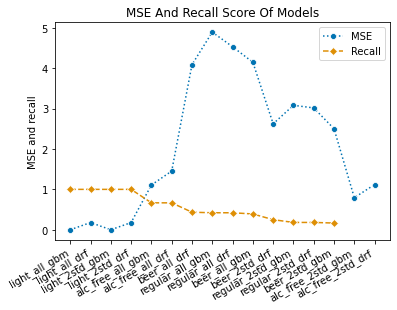

In [48]:
# Plot MSE and the recall score of each model to compare metrics.
fig, ax = plt.subplots()
sns.lineplot(x="model_name", y="mse", data=mse_recall, label="MSE", linestyle="dotted", marker="o")
sns.lineplot(x="model_name", y="recall", data=mse_recall, label="Recall", linestyle="dashed", marker="D")
ax.set(title="MSE And Recall Score Of Models", xlabel="", ylabel="MSE and recall")
ax.set_xticks(np.arange(len(mse_recall["model_name"])))
plt.xticks(rotation=30, horizontalalignment="right", verticalalignment="top")
ax.legend()
plt.show()
# MSE is lowest on models with maximum recall score, which is to be expected.
# However, MSE doesn't show a reverse pattern of recall. This proves that lower MSE doesn't necessarily mean a better model.

### 5.1.2 Approved Models.

           model_name       mse    recall model_type dataset_range
13      light_all_gbm  0.000022  1.000000        GBM           all
5       light_all_drf  0.179459  1.000000        DRF           all
12     light_2std_gbm  0.000022  1.000000        GBM         2-std
4      light_2std_drf  0.179459  1.000000        DRF         2-std
9    alc_free_all_gbm  1.107911  0.666667        GBM           all
1    alc_free_all_drf  1.451947  0.666667        DRF           all
3        beer_all_drf  4.084903  0.434783        DRF           all
15    regular_all_gbm  4.889677  0.421053        GBM           all
7     regular_all_drf  4.527368  0.421053        DRF           all
11       beer_all_gbm  4.144006  0.391304        GBM           all
2       beer_2std_drf  2.621286  0.250000        DRF         2-std
14   regular_2std_gbm  3.079163  0.181818        GBM         2-std
6    regular_2std_drf  3.014458  0.181818        DRF         2-std
10      beer_2std_gbm  2.499338  0.166667        GBM         2

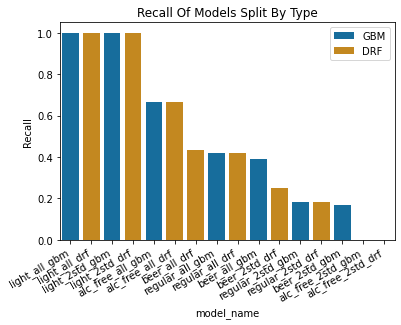

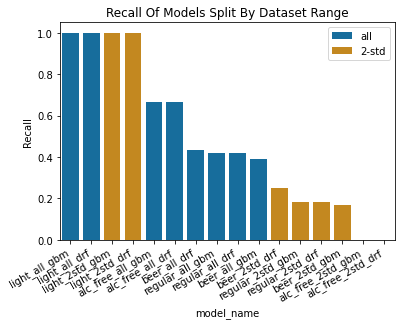

In [49]:
# Print MSE and recall dataframe.
print(mse_recall)

# Plot recall scores. Use dodge parameter to create even space between bars when using hue.
# Graph split by model type.
sns.barplot(x="model_name", y="recall", data=mse_recall, hue=mse_recall["model_type"], dodge=False)
plt.xticks(rotation=30, horizontalalignment="right", verticalalignment="top")
plt.ylabel(mse_recall["recall"].name.capitalize())
plt.title("recall of models split by type".title())
plt.legend(loc="upper right")
plt.show()
# Graph shows that DRF and GBM have the similar results for the same model, except for beer full range dataset where DRF performed better.
# Will use DRF models for predictions on the unseen dataset.

# Graph split by dataset range.
sns.barplot(x="model_name", y="recall", data=mse_recall, hue=mse_recall["dataset_range"], dodge=False)
plt.xticks(rotation=30, horizontalalignment="right", verticalalignment="top")
plt.ylabel(mse_recall["recall"].name.capitalize())
plt.title("recall of models split by dataset range".title())
plt.legend(loc="upper right")
plt.show()
# Graph shows that full range datasets generated better models than datasets with 2*std away ratings.
# This was to be expected because the goal of the project is to predict outliers, not the bulk of average ratings.
# Will keep outliers when testing the model on the unseen beer dataset.

## 5.2 Review Process.

### False negatives.

In [50]:
# Create function to input dictionary of frames and return dictionary of false negatives in each model:

def false_negatives_dictionary(input_dict, real_response_column, predict_column, threshold):
    """Select and export false negatives observations from model output dataframes.

    Args:
    input_dict (dict): Dictionary of dataframes and their names.
    real_response_column (str): The name of the response column containing numerical data as values.
    predict_column(str): The name of the predicted column containing numerical data as values.
    threshold (int, float): The threshold that separates outcomes.

    Returns:
    dict: Dictionary of dataframes with false negatives. Keys are names and values are pandas dataframes.
    .csv files of false negatives 
    """

    # Create empty dictionary to be populated at each iteration:
    fn_dict = {}

    # Iterate through input dictionary to extract each dataframe and its name:
    for key, value in input_dict.items():
        dataframe_name = str(key)
        
        # Select rows that contain false negatives:
        fn_dataframe = value[(value[real_response_column] < threshold) & (value[predict_column] >= threshold)]
        
        # Update empty dictionary with each false negative dataframe and its name:
        if not fn_dataframe.empty:
            # Define name for each false negatives dataframe:
            fn_name = dataframe_name + "_fn"
            fn_dict[fn_name] = fn_dataframe

            # Export false negatives.
            fn_dataframe.to_csv(os.getcwd() + os.sep + "beer_output" + os.sep + "false_negatives" + os.sep + fn_name + ".csv", index=False)
        else:
            pass
    return fn_dict


false_negatives = false_negatives_dictionary(predictions_dict, "rating", "predict", 5)

### False negatives split by occurence of observations in subgroups.

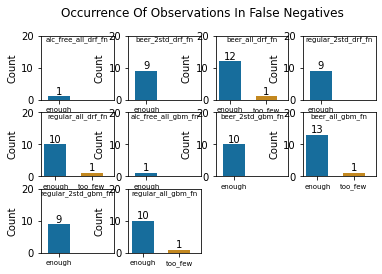

In [51]:
def plot_occurrences(fn_dictionary):
    """Subplots of false negatives split by occurrence in each dataset.

    Args:
    fn_dictionary (dict): Dictionary of dataframes and their names.

    Returns:
    Seaborn countplot in subplots of false negatives.
    """

    # Create figure and set its title:
    fig = plt.figure()
    fig.suptitle("Occurrence of observations in false negatives".title())
    # Start index of subplots:
    i=0

    # Iterate through input dictionary:
    for key, value in fn_dictionary.items():
        dataframe_name = str(key)

        # Add subplots sequentially.
        # Mark the first subplot as i+1 because subplot indices start at 1, and i is initialized at 0.
        ax = fig.add_subplot(3, 4, i+1)
        # Set title of subplot:
        ax.set_title(f"{dataframe_name}", fontsize=7, verticalalignment="top", y=0.9)
        
        # Select rows of each subgroup:
        too_few = value[value["occurrence"] == "too_few"]
        enough = value[value["occurrence"] == "enough"]

        # If both subgroups are present use whole dataframe for plotting, otherwise use the single series.
        # This helps when aligning labels.
        if len(too_few["occurrence"]) > 0:
            sns.countplot(x="occurrence", data=value, order=value["occurrence"].value_counts().index)
        else:
            sns.countplot(x="occurrence", data=enough)

        # Count bars to be plotted because it helps with setting bar width:
        bar_number = value["occurrence"].nunique()

        # Set bar width. Matplotlib divides the plot area into bars according to the number of bars. 
        # The float parameter provided by user is not used as a constant.
        # That's why setting a parameter dependent on number of bars cancels the division made by matplotlib.
        # This results in bars with the same width.
        for patch in ax.patches:
            patch.set_width(0.3*bar_number)
        # Show value counts of observations as labels on top of bars:
        ax.bar_label(ax.containers[0])

        # Set only y label to show they are counts.
        # An x label would crowd the figure because of limited space between rows of graphs.
        # The title of the whole figure already says what's on x axis.
        ax.set(xlabel="", ylabel="Count")

        # Calculate middle points of bars and use them to mark location of x-ticks:
        midpoints = [patch.get_x() + patch.get_width() / 2 for patch in ax.patches]
        ax.set_xticks(midpoints)
        # Define list of labels and set them under x-ticks:
        list_labels = list(value["occurrence"].value_counts().index)
        ax.set_xticklabels(list_labels, fontsize=7)

        # Set common y limit for all subplots in order to have the same scale when visualizing them:
        plt.ylim([0, 20])

        # Increment the index for the next subplot:
        i += 1
    
    # Show all graphs in one figure.
    plt.show()

plot_occurrences(false_negatives)

# Graphs show that most of the wrong predictions were generated for subgroups that had enough observations.

# 6. Deployment

### 6.1.1 Import and clean unseen file following the same steps as with seen data

In [53]:
# Import unseen file.
beer_unseen_raw = pd.read_csv(os.getcwd() + os.sep + "unseen_data" + os.sep + "unseen_input" + os.sep + "beer_unseen_raw.csv", header=0)


# Standardize appeareance. Convert column labels to lowercase.
beer_unseen_raw.columns = beer_unseen_raw.columns.str.lower()

# Convert columns values to lowercase if they are strings.
beer_unseen = beer_unseen_raw.applymap(lambda col:col.lower() if type(col) == str else col)

# Convert Name column from object to string.
beer_unseen["name"] = beer_unseen["name"].astype("string")

# Cut alcohol content from end of name and store as separate column.
beer_unseen["abv"] = [name.rsplit(maxsplit=1)[-1] for name in beer_unseen["name"]]

# Convert alcohol content to float.
beer_unseen["abv"] = beer_unseen["abv"].astype(float)

# Validation of uniqueness in beer names. Check for duplicates, remove if found.
beer_unseen.drop_duplicates(subset="name", keep="last", inplace=True)

# Create column for Pasteurization status.
beer_unseen["pasteurization"] = beer_unseen["name"].str.contains("|".join(unpasteurized_words))
beer_unseen["pasteurization"] = beer_unseen["pasteurization"].replace({True: "unpasteurized", False: "pasteurized"})

### 6.1.2 Create datasets based on alcohol content

In [54]:
# Split unseen dataset into alcohol-free, light and regular beer.
alc_free_unseen = beer_unseen[beer_unseen["abv"] <= 0.5]
light_unseen = beer_unseen[(beer_unseen["abv"] > 0.5) & (beer_unseen["abv"] <= 3)]
regular_unseen = beer_unseen[beer_unseen["abv"] > 3]

# Create list of unseen datasets, list of identificators and zip them.
clean_unseen = [alc_free_unseen, light_unseen, regular_unseen]
unseen_names = ["alc_free_unseen", "light_unseen", "regular_unseen"]
unseen_dict = dict(zip(unseen_names, clean_unseen))

# Export unseen datasets after cleaning.
unseen_clean_path = os.getcwd() + os.sep + "unseen_data" + os.sep + "unseen_output" + os.sep + "unseen_clean" + os.sep
os.getcwd() + os.sep + "unseen_data" + os.sep + "unseen_output" + os.sep + "unseen_clean" + os.sep

export_files_csv(unseen_dict, unseen_clean_path)

### 6.1.3 Apply ML models on unseen data

In [55]:
# Start H2O and import unseen files.
h2o.init(nthreads=-1, enable_assertions=False)
alc_free_unseen_frame = h2o.import_file(os.getcwd() + os.sep + "unseen_data" + os.sep + "unseen_output" + os.sep + "unseen_clean" + os.sep + "alc_free_unseen.csv")
light_unseen_frame = h2o.import_file(os.getcwd() + os.sep + "unseen_data" + os.sep + "unseen_output" + os.sep + "unseen_clean" + os.sep + "light_unseen.csv")
regular_unseen_frame = h2o.import_file(os.getcwd() + os.sep + "unseen_data" + os.sep + "unseen_output" + os.sep + "unseen_clean" + os.sep + "regular_unseen.csv")

# Import models trained models in step 4.3.3.
alc_free_imported_model = h2o.import_mojo(os.getcwd() + os.sep + "beer_output" + os.sep + "models" + os.sep + "drf_models" + os.sep + "alc_free_all_drf_model.zip")
light_imported_model = h2o.import_mojo(os.getcwd() + os.sep + "beer_output" + os.sep + "models" + os.sep + "drf_models" + os.sep + "light_all_drf_model.zip")
regular_imported_model = h2o.import_mojo(os.getcwd() + os.sep + "beer_output" + os.sep + "models" + os.sep + "drf_models" + os.sep + "regular_all_drf_model.zip")

# Select test rows
alc_free_unseen_test = alc_free_unseen_frame[alc_free_unseen_frame["split"]=="test"]
light_unseen_test = light_unseen_frame[light_unseen_frame["split"]=="test"]
regular_unseen_test = regular_unseen_frame[regular_unseen_frame["split"]=="test"]

# Generate predictions
alc_free_unseen_prediction = alc_free_imported_model.predict(alc_free_unseen_frame)
light_unseen_prediction = light_imported_model.predict(light_unseen_frame)
regular_unseen_prediction = regular_imported_model.predict(regular_unseen_frame)

# Calculate performance of model on test rows
alc_free_unseen_perf = alc_free_imported_model.model_performance(alc_free_unseen_test)
light_unseen_perf = light_imported_model.model_performance(light_unseen_test)
regular_unseen_perf = regular_imported_model.model_performance(regular_unseen_test)

# Store model performance as json into a dictionary.
alc_free_perf_dict = alc_free_unseen_perf._metric_json
light_perf_dict = light_unseen_perf._metric_json
regular_perf_dict = regular_unseen_perf._metric_json

# In alc_free and light there is a Warning:
# Test/Validation column “Style” has levels not trained on alt and “Flavor” has levels not trained on herb.
# This means that the training frame the model was built upon had no alt style and no herb flavor.

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,13 mins 10 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.5
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_alina_lo1sxu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.953 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
generic Model Build progress: |███████████████████████████████████████████| 100%
Model Details
H2OGenericEstimator :  Import MOJO Model
Model Key:  Generic_model_python_1630351044129_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,7164.0,3.0,5.0,3.58,5.0,9.0,6.78




ModelMetricsRegressionGeneric: generic
** Reported on train data. **

MSE: 3.2550422572782693
RMSE: 1.804173566284095
MAE: 1.3085873323336357
RMSLE: 0.27057938083659894
Mean Residual Deviance: 3.2550422572782693

ModelMetricsRegressionGeneric: generic
** Reported on validation data. **

MSE: 0.8285413788481186
RMSE: 0.9102424835438734
MAE: 0.8524333381652832
RMSLE: 0.11099399833774114
Mean Residual Deviance: 0.8285413788481186

ModelMetricsRegressionGeneric: generic
** Reported on cross-validation data. **

MSE: 5.199880822531256
RMSE: 2.280324718659879
MAE: 1.662801695551191
RMSLE: 0.35360302515241704
Mean Residual Deviance: 5.199880822531256

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid
0,mae,1.5303006,0.5947454,2.3342235,1.2222222,0.9685065,1.59625
1,mean_residual_deviance,4.294001,3.5962455,9.138018,1.7394148,1.3903383,4.9082346
2,mse,4.294001,3.5962455,9.138018,1.7394148,1.3903383,4.9082346
3,r2,-0.5473138,0.99359715,-2.035886,-0.11819524,-0.0018613952,-0.03331258
4,residual_deviance,4.294001,3.5962455,9.138018,1.7394148,1.3903383,4.9082346
5,rmse,1.934091,0.85890895,3.0229154,1.3188688,1.179126,2.2154536
6,rmsle,0.2830344,0.16131388,0.47584054,0.15403177,0.14574014,0.3565252



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2021-08-30 21:17:37,0.212 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2021-08-30 21:17:37,0.216 sec,1.0,1.921765,1.272727,3.693182,1.083974,1.000000,1.175000
2,,2021-08-30 21:17:37,0.219 sec,2.0,2.095106,1.421296,4.389468,1.259133,1.200000,1.585417
3,,2021-08-30 21:17:37,0.221 sec,3.0,2.050802,1.386111,4.205787,1.149074,1.100000,1.320370
4,,2021-08-30 21:17:37,0.224 sec,4.0,1.853896,1.304977,3.436930,1.109030,1.054167,1.229948
5,,2021-08-30 21:17:37,0.226 sec,5.0,1.811318,1.259445,3.280872,1.139225,1.083333,1.297833
6,,2021-08-30 21:17:37,0.229 sec,6.0,1.772435,1.212554,3.141525,1.173537,1.112778,1.377190
7,,2021-08-30 21:17:37,0.232 sec,7.0,1.664225,1.194693,2.769645,1.099319,1.049048,1.208502
8,,2021-08-30 21:17:37,0.234 sec,8.0,1.639003,1.164513,2.686330,1.074339,1.024167,1.154205
9,,2021-08-30 21:17:37,0.237 sec,9.0,1.660614,1.192588,2.757639,1.028428,0.977037,1.057664



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,flavor,1429.977417,1.000000,0.764415
1,style,440.703461,0.308189,0.235585



generic Model Build progress: |███████████████████████████████████████████| 100%
Model Details
H2OGenericEstimator :  Import MOJO Model
Model Key:  Generic_model_python_1630351044129_2


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,7722.0,2.0,7.0,5.5,4.0,11.0,7.68




ModelMetricsRegressionGeneric: generic
** Reported on train data. **

MSE: 1.235150977635391
RMSE: 1.111373464518292
MAE: 0.9517779795630711
RMSLE: 0.13258934415966211
Mean Residual Deviance: 1.235150977635391

ModelMetricsRegressionGeneric: generic
** Reported on validation data. **

MSE: 1.2126468931174583
RMSE: 1.1012024759858916
MAE: 0.8903703541225858
RMSLE: 0.1489323513001758
Mean Residual Deviance: 1.2126468931174583

ModelMetricsRegressionGeneric: generic
** Reported on cross-validation data. **

MSE: 1.6853055523766414
RMSE: 1.29819318761756
MAE: 1.0661111089918347
RMSLE: 0.1601178938711908
Mean Residual Deviance: 1.6853055523766414

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid
0,mae,1.2341666,0.66469634,1.1216667,2.205,0.836,0.774
1,mean_residual_deviance,2.158595,1.8922393,1.87575,4.90405,1.14172,0.71286
2,mse,2.158595,1.8922393,1.87575,4.90405,1.14172,0.71286
3,r2,-0.43590045,0.4029061,-0.20583929,-0.2260125,-1.0387857,-0.27296427
4,residual_deviance,2.158595,1.8922393,1.87575,4.90405,1.14172,0.71286
5,rmse,1.3742281,0.60010225,1.3695803,2.214509,1.068513,0.84431034
6,rmsle,0.1720987,0.09588203,0.1541405,0.31227103,0.11939263,0.10259058



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2021-08-30 21:17:41,0.194 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2021-08-30 21:17:41,0.197 sec,1.0,1.154701,1.000000,1.333333,1.414214,1.111111,2.000000
2,,2021-08-30 21:17:41,0.199 sec,2.0,1.083974,0.950000,1.175000,1.399956,1.129630,1.959877
3,,2021-08-30 21:17:41,0.201 sec,3.0,1.373450,1.136364,1.886364,1.443970,1.135802,2.085048
4,,2021-08-30 21:17:41,0.203 sec,4.0,1.394599,1.172222,1.944907,1.274906,0.990741,1.625386
5,,2021-08-30 21:17:41,0.205 sec,5.0,1.237788,1.072917,1.532118,1.182851,0.862963,1.399136
6,,2021-08-30 21:17:41,0.208 sec,6.0,1.205753,1.034314,1.453840,1.198386,0.885802,1.436128
7,,2021-08-30 21:17:41,0.210 sec,7.0,1.234009,1.068519,1.522778,1.181847,0.886243,1.396762
8,,2021-08-30 21:17:41,0.212 sec,8.0,1.232466,1.064043,1.518972,1.129001,0.877315,1.274643
9,,2021-08-30 21:17:41,0.214 sec,9.0,1.222015,1.068056,1.493322,1.139771,0.866255,1.299078



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,abv,737.083740,1.000000,0.728621
1,style,224.800568,0.304986,0.222220
2,flavor,49.729881,0.067468,0.049159



generic Model Build progress: |███████████████████████████████████████████| 100%
Model Details
H2OGenericEstimator :  Import MOJO Model
Model Key:  Generic_model_python_1630351044129_3


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,28463.0,9.0,15.0,11.64,33.0,47.0,40.54




ModelMetricsRegressionGeneric: generic
** Reported on train data. **

MSE: 4.164599901362763
RMSE: 2.040735137484226
MAE: 1.5678926203224623
RMSLE: 0.3564457513912533
Mean Residual Deviance: 4.164599901362763

ModelMetricsRegressionGeneric: generic
** Reported on validation data. **

MSE: 7.11750707744059
RMSE: 2.6678656408148798
MAE: 1.8995151522665317
RMSLE: Infinity
Mean Residual Deviance: 7.11750707744059

ModelMetricsRegressionGeneric: generic
** Reported on cross-validation data. **

MSE: 4.958979566358996
RMSE: 2.2268766392324015
MAE: 1.7202925177009738
RMSLE: 0.42815297745945885
Mean Residual Deviance: 4.958979566358996

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid
0,mae,1.7218333,0.22401166,1.6106896,1.8604444,1.4645833,1.9516162
1,mean_residual_deviance,5.082975,1.476251,3.686388,6.4217515,3.9300375,6.2937217
2,mse,5.082975,1.476251,3.686388,6.4217515,3.9300375,6.2937217
3,r2,-0.9463101,0.849245,-1.3310169,-1.9356579,-0.47472417,-0.043841477
4,residual_deviance,5.082975,1.476251,3.686388,6.4217515,3.9300375,6.2937217
5,rmse,2.236319,0.3303581,1.9199969,2.5341175,1.9824322,2.5087292
6,rmsle,0.40266213,0.09929934,0.38358608,0.3760141,0.3083454,0.5427029



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2021-08-30 21:17:42,0.277 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2021-08-30 21:17:42,0.281 sec,1.0,2.276801,1.661765,5.183824,2.941346,2.090909,8.651515
2,,2021-08-30 21:17:42,0.284 sec,2.0,2.396117,1.673023,5.741378,2.839880,2.065657,8.064920
3,,2021-08-30 21:17:42,0.286 sec,3.0,2.454584,1.767407,6.024985,2.623453,1.943603,6.882506
4,,2021-08-30 21:17:42,0.289 sec,4.0,2.358754,1.695575,5.563720,2.631037,1.928535,6.922358
5,,2021-08-30 21:17:42,0.292 sec,5.0,2.361219,1.716635,5.575356,2.582150,1.905455,6.667501
6,,2021-08-30 21:17:42,0.295 sec,6.0,2.307293,1.651404,5.323602,2.581415,1.877273,6.663702
7,,2021-08-30 21:17:42,0.297 sec,7.0,2.269419,1.623860,5.150264,2.596050,1.891198,6.739473
8,,2021-08-30 21:17:42,0.300 sec,8.0,2.285275,1.663257,5.222482,2.624690,1.909091,6.889000
9,,2021-08-30 21:17:42,0.302 sec,9.0,2.295572,1.676978,5.269652,2.626064,1.904433,6.896212



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,style,4820.410156,1.000000,0.512429
1,abv,3604.914062,0.747844,0.383217
2,flavor,567.800293,0.117791,0.060360
3,pasteurization,413.849884,0.085854,0.043994



generic prediction progress: |████████████████████████████████████████████| 100%


E:\Python382\lib\site-packages\h2o\job.py:72: UserWarning: Test/Validation dataset column 'style' has levels not trained on: ["alt"]
  warnings.warn(w)


generic prediction progress: |████████████████████████████████████████████| 100%


E:\Python382\lib\site-packages\h2o\job.py:72: UserWarning: Test/Validation dataset column 'flavor' has levels not trained on: ["herb"]
  warnings.warn(w)


generic prediction progress: |████████████████████████████████████████████| 100%


### 6.1.4 Export predictions

In [56]:
# Frames plus predictions
alc_free_unseen_plus_pred = alc_free_unseen_frame.cbind(alc_free_unseen_prediction)
light_unseen_plus_pred = light_unseen_frame.cbind(light_unseen_prediction)
regular_unseen_plus_pred = regular_unseen_frame.cbind(regular_unseen_prediction)

# Convert frames to dataframes
alc_free_unseen_pred_df = alc_free_unseen_plus_pred.as_data_frame()
light_unseen_pred_df = light_unseen_plus_pred.as_data_frame()
regular_unseen_pred_df = regular_unseen_plus_pred.as_data_frame()

# Create list of unseen predictions ad zip them with dataset identificators.
unseen_predictions = [alc_free_unseen_pred_df, light_unseen_pred_df, regular_unseen_pred_df]
unseen_predictions_dict = dict(zip(unseen_names, unseen_predictions))

# Export prediction dataframe.
alc_free_unseen_pred_df.to_csv(os.getcwd() + os.sep + "unseen_data" + os.sep + "unseen_output" + os.sep + "unseen_predictions" + os.sep + "alc_free_unseen_pred.csv", index=False)
light_unseen_pred_df.to_csv(os.getcwd() + os.sep + "unseen_data" + os.sep + "unseen_output" + os.sep + "unseen_predictions" + os.sep + "light_unseen_pred.csv", index=False)
regular_unseen_pred_df.to_csv(os.getcwd() + os.sep + "unseen_data" + os.sep + "unseen_output" + os.sep + "unseen_predictions" + os.sep + "regular_unseen_pred.csv", index=False)

### 6.1.5 Calculate recall

In [57]:
# Write function to calculate and export recall scores.

def calculate_recall(dict_of_predictions):
    """Calculate recall score of predictions and export them to csv file.

    Possible values of recall score are between 0 and 1.
    The function returns "np.NaN" if the total number of true positives plus false negatives is zero.

    Args:
    dict_of_predictions (dict): Dictionary of dataframes and their names.

    Returns:
    csv file with recall scores.
    """
    
    recall_list = []
    for key, value in dict_of_predictions.items():
        name = str(key)

        tp = value[(value["rating"] < 5) & (value["predict"] < 5)]
        fn = value[(value["rating"] < 5) & (value["predict"] >= 5)]
        
        # Export fn dataframe.
        fn.to_csv(os.getcwd() + os.sep + "unseen_data" + os.sep + "unseen_output" + os.sep + "unseen_false_negatives" + os.sep + name + ".csv", index=False)
        

        # Calculate recall score:
        try:
            recall = len(tp) / (len(tp) + len(fn))
        except ZeroDivisionError:
            recall = np.NaN
        
        # Append recall to score list.
        recall_list.append(recall)
        
    # Zip unseen names and recall scores into a pandas dataframe.
    recall_df = pd.DataFrame(zip(unseen_names, recall_list), columns=["model_name", "recall"])

    # Export recall dataframe to csv file.
    recall_df.to_csv(os.getcwd() + os.sep + "unseen_data" + os.sep + "unseen_output" + os.sep + "unseen_metrics" + os.sep + "recall_unseen.csv", index=False)

calculate_recall(unseen_predictions_dict)

### 6.1.6 Evaluate results

        model_name    recall
2   regular_unseen  0.285714
0  alc_free_unseen  0.000000
1     light_unseen       NaN


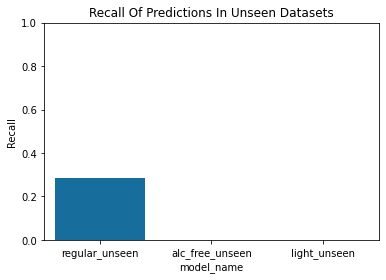

In [58]:
# Import recall file of unseen datasets.
recall_unseen = pd.read_csv(os.getcwd() + os.sep + "unseen_data" + os.sep + "unseen_output" + os.sep + "unseen_metrics" + os.sep + "recall_unseen.csv")

# Sort recall dataframe by score.
recall_unseen.sort_values("recall", ascending=False, inplace=True )

# Print recall dataframe.
print(recall_unseen)


# Plot recall scores.
sns.barplot(x="model_name", y="recall", data=recall_unseen)
plt.title("recall of predictions in unseen datasets".title())
plt.ylabel("Recall")
plt.ylim([0, 1])
plt.show()
# Graph shows that regular beer is the only one from which low rated beer was detected.
# Alcohol-free and light beers either had a scoze of 0, or didn't have low rated beer in the dataset.
# It's possible to improve these scores or lack of score by collecting more data.

In [59]:
# Print total number of rows and ratings lower than 5 in each unseen dataset to bring context for recall score.

for key, value in unseen_dict.items():
    total_rows = value.shape[0]
    lower_than_five = value[value["rating"] < 5]
    only_lows = lower_than_five.shape[0]
    print(f"{key} \nRows: {total_rows} \nNumber of ratings lower than 5: {only_lows} \n")

alc_free_unseen 
Rows: 13 
Number of ratings lower than 5: 1 

light_unseen 
Rows: 9 
Number of ratings lower than 5: 0 

regular_unseen 
Rows: 59 
Number of ratings lower than 5: 7 

